# ⚙️ Configurazioni inziali

## 📦 1. IMPORT LIBRERIE

In [1]:
# Installazione delle librerie necessarie (eseguire solo se non già installate)
# %pip install pandas numpy matplotlib seaborn statsmodels

In [2]:
# Librerie essenziali
import pandas as pd
import numpy as np
# Librerie per la visualizzazione dei dati
import matplotlib.pyplot as plt
import seaborn as sns
# Librerie per l'analisi delle serie temporali
from scipy import stats
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Configurazione stile grafici
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

## 📂 2. CARICAMENTO DATI

In [5]:
# Caricamento dati
file_path = 'Consumo_energetico+Presenze.csv'
df = pd.read_csv(file_path, sep=';')

In [6]:
df.head()

,n_bolletta,Data,fasce_1_kWh,fasce_2_kWh,fasce_3_kWh,Total_kWh,Presenze
0,2021/0192381,2021-01,278,158,303,739,38
1,2021/0584462,2021-02,273,126,220,619,41
2,2021/1115959,2021-03,255,149,255,659,48
3,2021/1554199,2021-04,250,136,255,641,60
4,2021/1942557,2021-05,238,140,282,660,70


## 🔧 3. DATA CLEANING & PREPROCESSING

In [7]:
# Visualizzare info sul dataset
print("\n" + "=" * 70)
print("📊 INFORMAZIONI DATASET")
print("=" * 70)
print(df.info())


📊 INFORMAZIONI DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   n_bolletta   44 non-null     object
 1   Data         44 non-null     object
 2   fasce_1_kWh  44 non-null     int64 
 3   fasce_2_kWh  44 non-null     int64 
 4   fasce_3_kWh  44 non-null     int64 
 5   Total_kWh    44 non-null     int64 
 6   Presenze     44 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 2.5+ KB
None


In [8]:
# Rinomina delle colonne affinché inizino con una lettera minuscola
df.columns = ['n_bolletta', 'data', 'f1_kWh', 'f2_kWh', 'f3_kWh', 'total_kWh', 'presenze']

In [9]:
# Convertire la colonna data in datetime
df['data'] = pd.to_datetime(df['data'], format='%Y-%m')

In [10]:
# Ordinare per data
df = df.sort_values('data').reset_index(drop=True)

In [11]:
# Verifica missing values
print("\n" + "=" * 70)
print("🔍 CONTROLLO MISSING VALUES")
print("=" * 70)
missing = df.isnull().sum()
print(missing)

if missing.sum() == 0:
    print("\n✅ Nessun valore mancante!")
else:
    print(f"\n⚠️ Trovati {missing.sum()} valori mancanti")


🔍 CONTROLLO MISSING VALUES
n_bolletta    0
data          0
f1_kWh        0
f2_kWh        0
f3_kWh        0
total_kWh     0
presenze      0
dtype: int64

✅ Nessun valore mancante!


In [12]:
# Creare feature temporali
df['anno'] = df['data'].dt.year
df['mese'] = df['data'].dt.month
df['trimestre'] = df['data'].dt.quarter
df['mese_nome'] = df['data'].dt.month_name()

In [13]:
# Creare colonna stagionale
def get_season(month):
    if month in [12, 1, 2]:
        return 'Inverno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Estate'
    else:
        return 'Autunno'

In [14]:
df['stagione'] = df['mese'].apply(get_season)

In [15]:
print("\n" + "=" * 70)
print("✅ PREPROCESSING COMPLETATO")
print("=" * 70)
print(f"\n📋 Colonne finali:\n")
print(df.columns.tolist())
print(f"\n📊 Dataset preprocessato (prime 3 righe):\n")
print(df.head(3))


✅ PREPROCESSING COMPLETATO

📋 Colonne finali:

['n_bolletta', 'data', 'f1_kWh', 'f2_kWh', 'f3_kWh', 'total_kWh', 'presenze', 'anno', 'mese', 'trimestre', 'mese_nome', 'stagione']

📊 Dataset preprocessato (prime 3 righe):

     n_bolletta       data  f1_kWh  f2_kWh  f3_kWh  total_kWh  presenze  anno  \
0  2021/0192381 2021-01-01     278     158     303        739        38  2021   
1  2021/0584462 2021-02-01     273     126     220        619        41  2021   
2  2021/1115959 2021-03-01     255     149     255        659        48  2021   

   mese  trimestre mese_nome   stagione  
0     1          1   January    Inverno  
1     2          1  February    Inverno  
2     3          1     March  Primavera  


# 📊 Analisi Esplorativa dei Dati (EDA)

## **Obiettivo:** Analizzare i consumi energetici mensili per fasce orarie (F1, F2, F3) e la loro relazione con le presenze in ufficio.

N.B.:
- Fascia F1 (ore di punta): dalle 8.00 alle 19.00 nei giorni dal lunedì al venerdì, escluse le festività nazionali; 
- Fascia F2  (ore intermedie): dalle 7.00 alle 8.00 e dalle 19.00 alle 23.00 nei giorni dal lunedì al venerdì e dalle 7.00 alle 23.00 del sabato, escluse le festività nazionali; 
- Fascia F3 (ore fuori punta): dalle 23.00 alle 7.00 nei giorni dal lunedì al sabato e tutte le ore dei giorni di domenica e festività nazionali.

## 📊 4. STATISTICHE DESCRITTIVE

In [16]:
print("=" * 70)
print("📈 STATISTICHE DESCRITTIVE")
print("=" * 70)
print(df[['f1_kWh', 'f2_kWh', 'f3_kWh', 'total_kWh', 'presenze']].describe())

📈 STATISTICHE DESCRITTIVE
           f1_kWh      f2_kWh      f3_kWh   total_kWh    presenze
count   44.000000   44.000000   44.000000   44.000000   44.000000
mean   164.750000   81.113636  140.704545  386.568182   64.000000
std     68.474787   55.311051   86.439542  201.323227   24.815599
min     67.000000   34.000000   56.000000  189.000000    0.000000
25%    111.000000   41.000000   76.500000  225.000000   53.000000
50%    143.000000   48.000000   88.000000  264.500000   65.000000
75%    229.250000  136.000000  222.000000  630.500000   81.250000
max    296.000000  220.000000  303.000000  739.000000  110.000000


In [17]:
# Media aritmetica per anno
print("\n" + "=" * 70)
print("📊 MEDIA ARITMETICA PER ANNO")
print("=" * 70)
print(df.groupby('anno')[['f1_kWh', 'f2_kWh', 'f3_kWh', 'total_kWh', 'presenze']].mean())


📊 MEDIA ARITMETICA PER ANNO
          f1_kWh      f2_kWh   f3_kWh   total_kWh   presenze
anno                                                        
2021  253.166667  145.833333  268.000  667.000000  64.750000
2022  138.250000   76.416667  110.500  325.166667  65.916667
2023  130.083333   45.583333   83.500  259.166667  62.666667
2024  123.875000   44.375000   80.875  249.125000  62.000000


In [18]:
# Media aritmetica per stagione
print("\n" + "=" * 70)
print("🍂 MEDIA ARITMETICA PER STAGIONE")
print("=" * 70)
print(df.groupby('stagione')[['f1_kWh', 'f2_kWh', 'f3_kWh', 'total_kWh', 'presenze']].mean())


🍂 MEDIA ARITMETICA PER STAGIONE
               f1_kWh      f2_kWh      f3_kWh   total_kWh   presenze
stagione                                                            
Autunno    189.777778  106.666667  172.000000  468.444444  80.333333
Estate     144.500000   74.333333  133.000000  351.833333  54.750000
Inverno    189.636364   85.909091  145.909091  421.454545  55.636364
Primavera  143.416667   64.333333  120.166667  327.916667  68.666667


## 📈 5. ANALISI TREND TEMPORALE

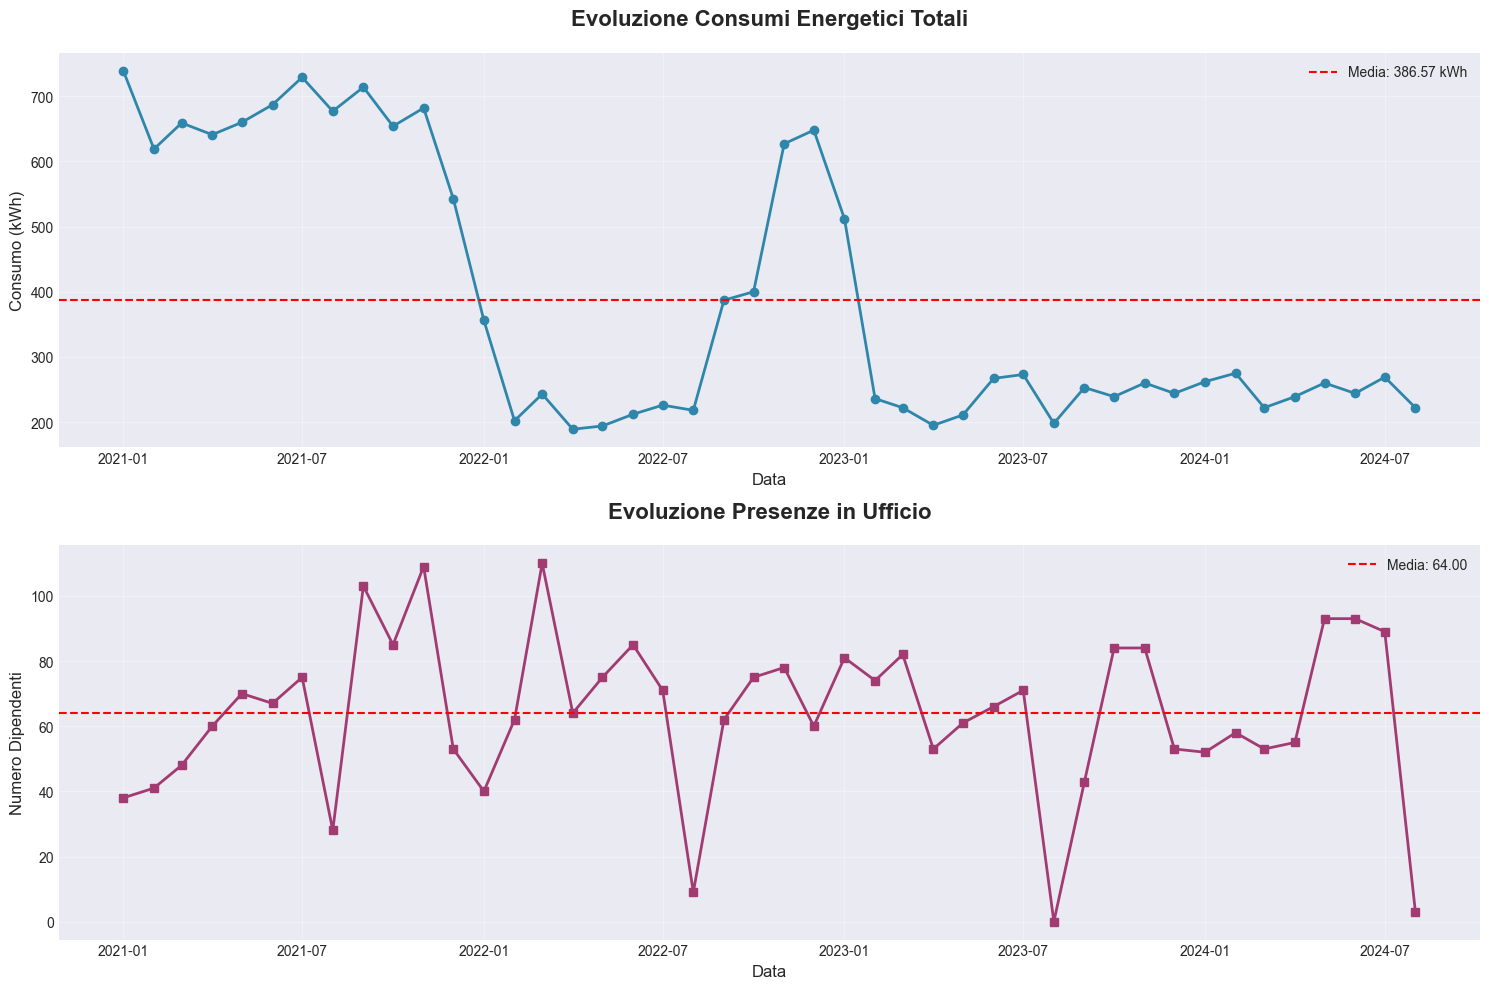

In [19]:
# Plot consumi totali nel tempo
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Grafico 1: Consumi totali
axes[0].plot(df['data'], df['total_kWh'], marker='o', linewidth=2, markersize=6, color='#2E86AB')
axes[0].set_title('Evoluzione Consumi Energetici Totali', fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel('Data', fontsize=12)
axes[0].set_ylabel('Consumo (kWh)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(df['total_kWh'].mean(), color='red', linestyle='--', label=f'Media: {df["total_kWh"].mean():.2f} kWh')
axes[0].legend()

# Grafico 2: Presenze nel tempo
axes[1].plot(df['data'], df['presenze'], marker='s', linewidth=2, markersize=6, color='#A23B72')
axes[1].set_title('Evoluzione Presenze in Ufficio', fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel('Data', fontsize=12)
axes[1].set_ylabel('Numero Dipendenti', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(df['presenze'].mean(), color='red', linestyle='--', label=f'Media: {df["presenze"].mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

Dal trend dei consumi energetici totali e di presenze in ufficio si evince una relazione quasi negativa tra le variabili.

Si osserva inoltre un cambiamento strutturale netto:
- Pre-2022: consumi elevati (600-730 kWh) con presenze basse/moderate (40-110 persone)
- Post-2022: consumi bassi (200-280 kWh) con presenze variabili ma generalmente sotto la media

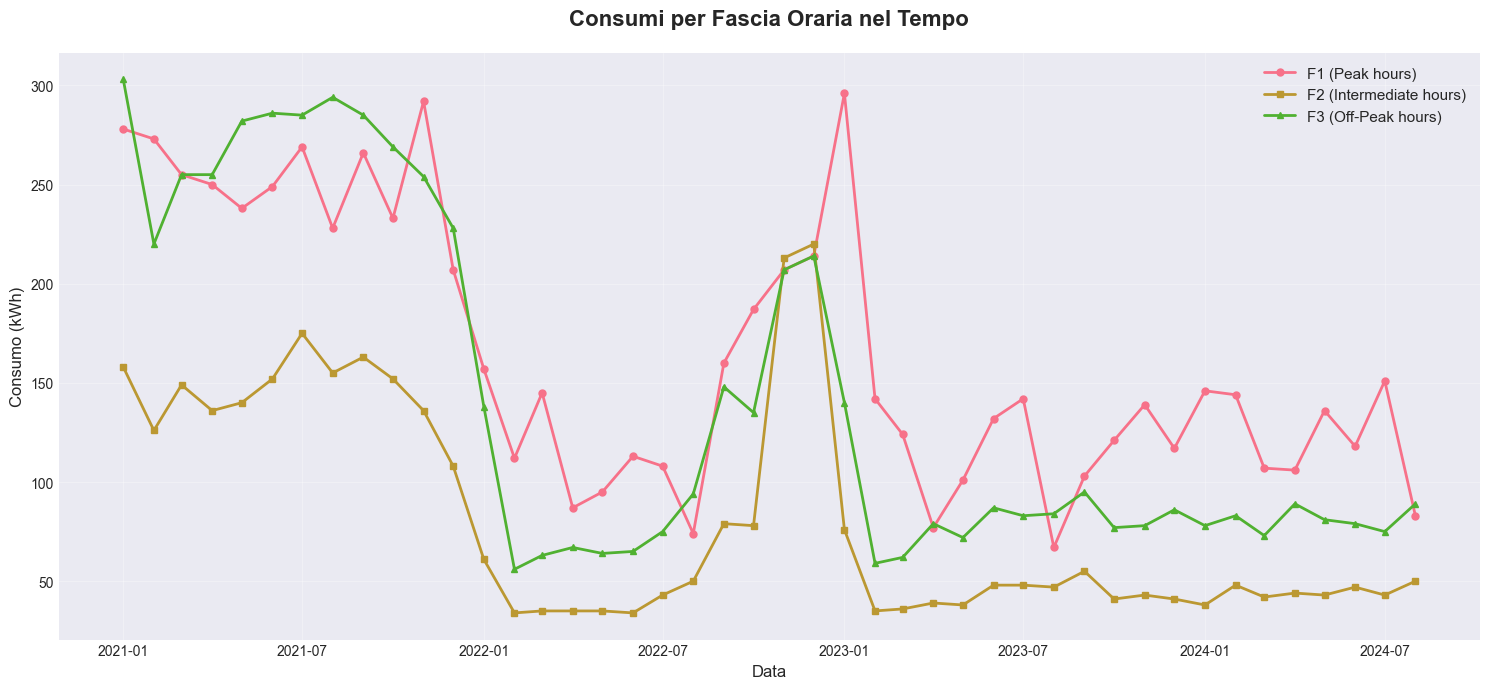

In [20]:
# Plot consumi per fascia oraria
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(df['data'], df['f1_kWh'], marker='o', label='F1 (Peak hours)', linewidth=2, markersize=5)
ax.plot(df['data'], df['f2_kWh'], marker='s', label='F2 (Intermediate hours)', linewidth=2, markersize=5)
ax.plot(df['data'], df['f3_kWh'], marker='^', label='F3 (Off-Peak hours)', linewidth=2, markersize=5)

ax.set_title('Consumi per Fascia Oraria nel Tempo', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Consumo (kWh)', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Analizando il trend delle fasce orarie emerge una sorta di convergenza delle fasce tariffarie:

Pre-2022: Le tre fasce erano nettamente differenziate:
- F3: 220-305 kWh
- F1: 230-295 kWh
- F2: 130-175 kWh

Post-2023: Forte convergenza e inversione gerarchica:
- F1, F2, F3 si attestano tutte su livelli simili (40-150 kWh)
- La differenziazione si riduce

## 🔄 6. ANALISI STAGIONALITÀ

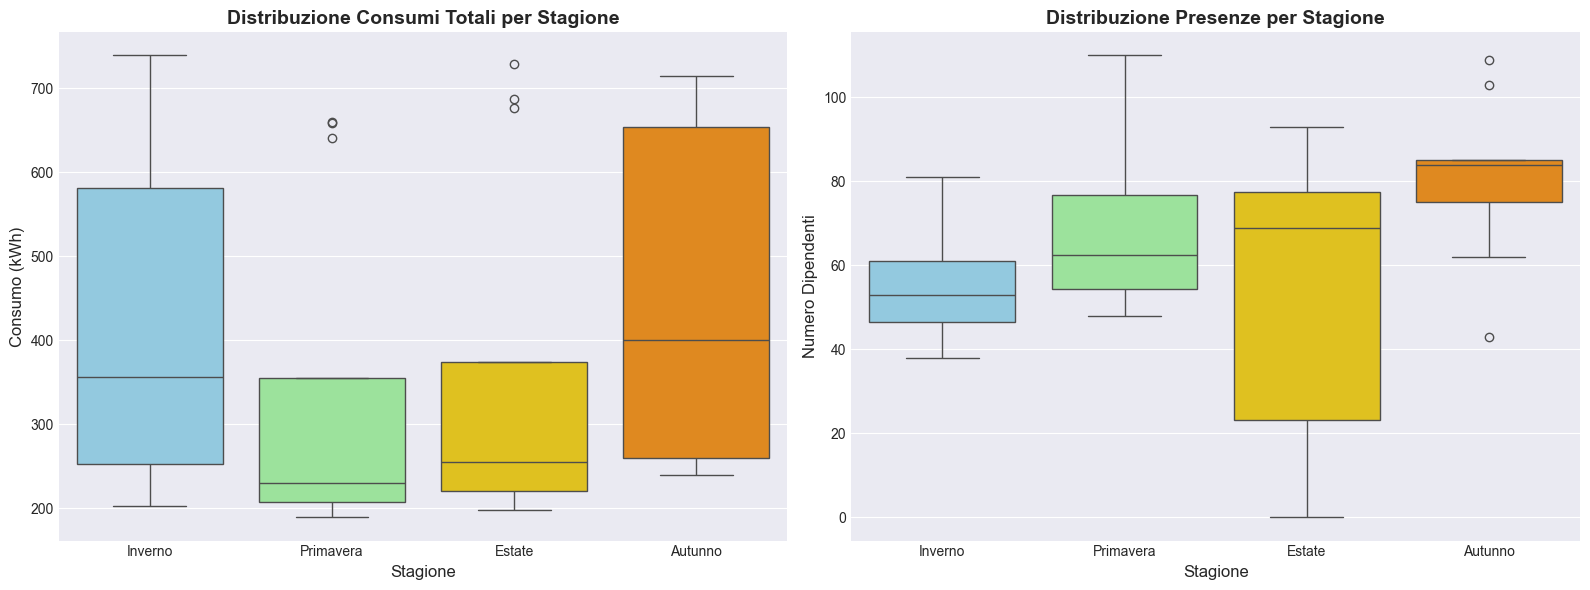

In [21]:
# Box plot per stagione
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Si definiscono i colori per ogni stagione
colori_stagioni = ['#87CEEB', '#90EE90', '#FFD700', '#FF8C00']  # Inverno, Primavera, Estate, Autunno

# Consumi totali per stagione
sns.boxplot(data=df, x='stagione', y='total_kWh', ax=axes[0], 
            order=['Inverno', 'Primavera', 'Estate', 'Autunno'], palette=colori_stagioni)
axes[0].set_title('Distribuzione Consumi Totali per Stagione', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stagione', fontsize=12)
axes[0].set_ylabel('Consumo (kWh)', fontsize=12)

# Presenze per stagione
sns.boxplot(data=df, x='stagione', y='presenze', ax=axes[1],
            order=['Inverno', 'Primavera', 'Estate', 'Autunno'], palette=colori_stagioni)
axes[1].set_title('Distribuzione Presenze per Stagione', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Stagione', fontsize=12)
axes[1].set_ylabel('Numero Dipendenti', fontsize=12)

plt.tight_layout()
plt.show()

- Autunno ha i consumi mensili più alti (mediana ~400 kWh mensili)
- Estate e Primavera i più bassi (~250-260 kWh mensili)
- L'alta variabilità in Autunno suggerisce differenze marcate tra settembre (possibili temperature ancora elevate) e novembre (temperature già più basse)

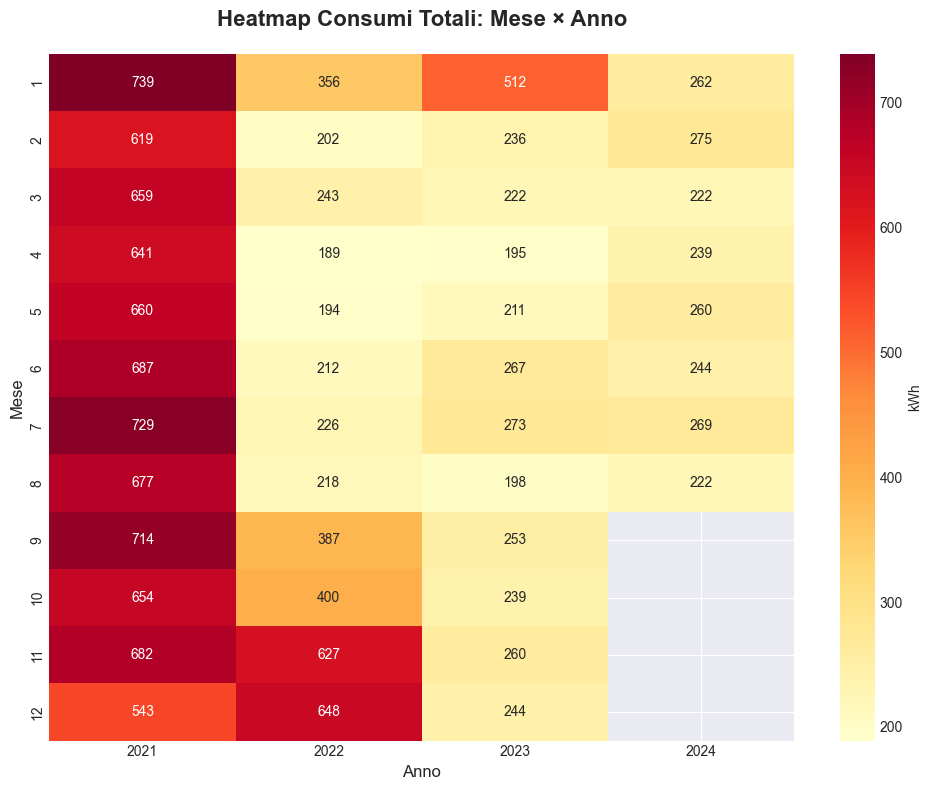

In [22]:
# Heatmap consumi per mese e anno
pivot_total = df.pivot_table(values='total_kWh', index='mese', columns='anno', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_total, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'kWh'})
plt.title('Heatmap Consumi Totali: Mese × Anno', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Anno', fontsize=12)
plt.ylabel('Mese', fontsize=12)
plt.tight_layout()
plt.show()

### Stagionalità bimodale attenuata:

- I picchi invernali (riscaldamento) sono molto più pronunciati dei picchi estivi (raffrescamento)
- Nei mesi estivi (giugno-agosto) i consumi rimangono relativamente bassi (198-275 kWh), suggerendo:
  - Sistema di climatizzazione efficiente o poco utilizzato
  - Possibile riduzione dell'attività lavorativa in estate (ferie)
  - Buon isolamento termico dell'edificio

### Analisi del Trend Decrescente
La riduzione drastica dei consumi dal 2021 al 2024 è molto significativa e potrebbe essere spiegata da:

Ipotesi più probabile - Cambio modalità lavoro:
- Passaggio a modelli ibridi/smart working post-pandemia
- Riduzione della presenza fisica in ufficio
- Gennaio 2021: 739 kWh → Gennaio 2024: 282 kWh (-62%)

Altre possibilità sono:
- Interventi di riqualificazione energetica (2022-2023): cappotto termico, sostituzione caldaia, LED
- Riduzione del personale o razionalizzazione degli spazi utilizzati
- Cambio fornitore

### Anomalia da Investigare
Il picco di dicembre 2022 (648 kWh) è anomalo rispetto al trend decrescente - potrebbe indicare un ultimo inverno a pieno regime prima di cambiamenti organizzativi (smart working)

## 🔗 7. CORRELAZIONI

In [23]:
# Matrice di correlazione
correlation_cols = ['f1_kWh', 'f2_kWh', 'f3_kWh', 'total_kWh', 'presenze']
corr_matrix = df[correlation_cols].corr()

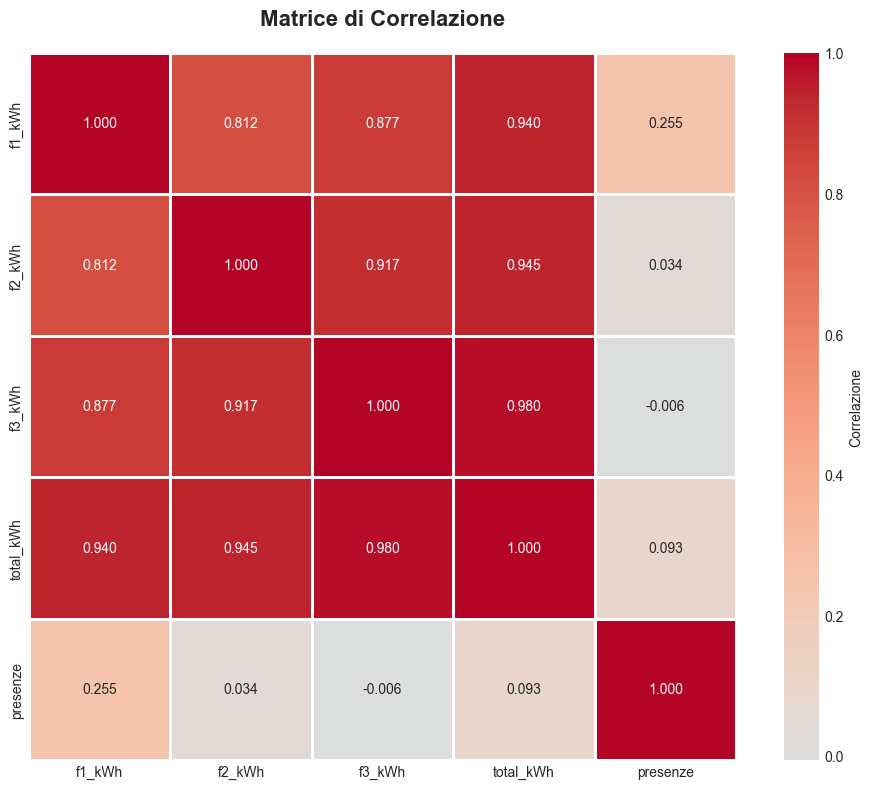

In [24]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={'label': 'Correlazione'})
plt.title('Matrice di Correlazione', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### **Scoperta Chiave**
Le presenze sono praticamente non correlate ai consumi:

- presenze-f1: 0.255
- presenze-f2: 0.034
- presenze-f3: -0.006
- presenze-total: 0.093

### Implicazioni Econometriche
Questa correlazione quasi nulla smonta l'ipotesi dello smart working come causa principale della riduzione dei consumi. 

Se le presenze in ufficio non influenzano significativamente i consumi, la riduzione osservata non può essere attribuita ad un calo delle presenze.

### ======================================================================
### 📊 PRINCIPALI CORRELAZIONI
### ======================================================================

In [25]:
# Correlazioni con Total_kWh
print("\n✅ Correlazioni con Consumo Totale:")
print(corr_matrix['total_kWh'].sort_values(ascending=False))


✅ Correlazioni con Consumo Totale:
total_kWh    1.000000
f3_kWh       0.979806
f2_kWh       0.944833
f1_kWh       0.940047
presenze     0.093452
Name: total_kWh, dtype: float64


In [26]:
# Correlazioni con Presenze
print("\n👥 Correlazioni con Presenze:")
print(corr_matrix['presenze'].sort_values(ascending=False))


👥 Correlazioni con Presenze:
presenze     1.000000
f1_kWh       0.254765
total_kWh    0.093452
f2_kWh       0.033819
f3_kWh      -0.005800
Name: presenze, dtype: float64


Le correlazioni molto elevate tra le fasce orarie indica che i consumi si muovono in modo sincronizzato nelle diverse fasce, considerando anche la non correlazione tra consumi e presenze si può dedurre che:
- L'ufficio ha dei consumi continui, indipendenti dalle presenze
- Il consumo legato alle presenze è marginale rispetto al totale

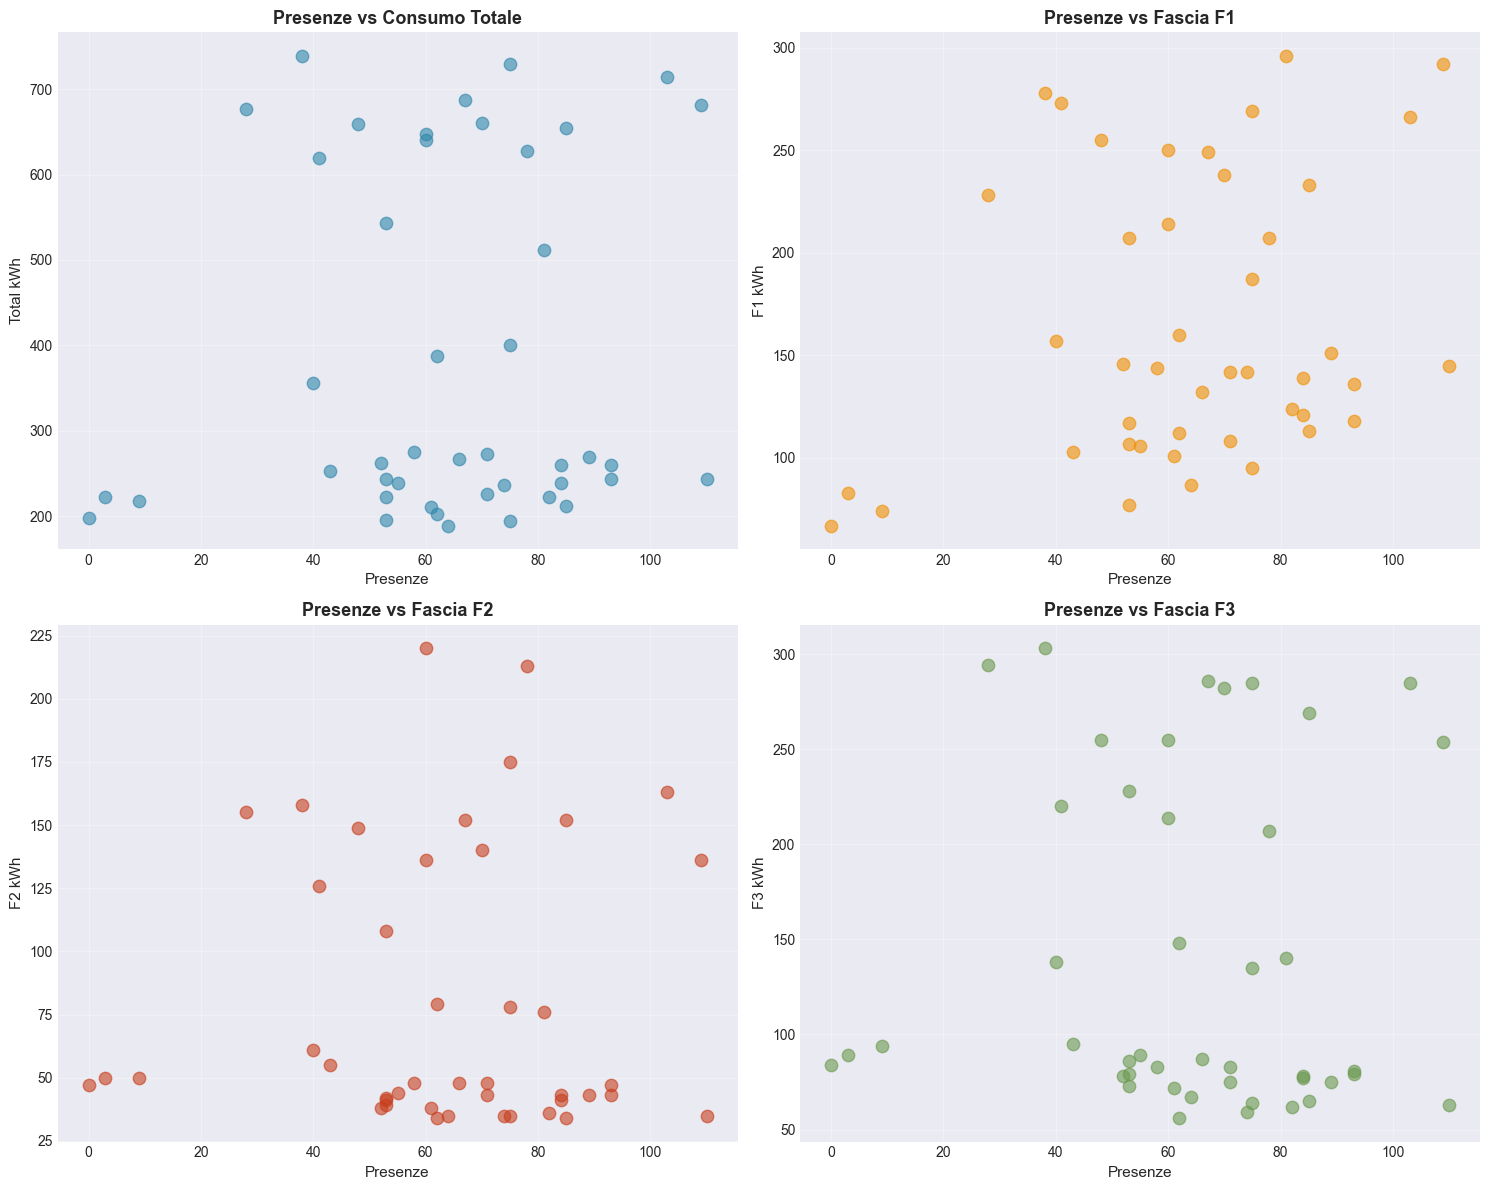

In [27]:
# Scatter plot: Presenze vs Consumi
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Presenze vs Total
axes[0, 0].scatter(df['presenze'], df['total_kWh'], alpha=0.6, s=80, color='#2E86AB')
axes[0, 0].set_title('Presenze vs Consumo Totale', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Presenze', fontsize=11)
axes[0, 0].set_ylabel('Total kWh', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Presenze vs F1
axes[0, 1].scatter(df['presenze'], df['f1_kWh'], alpha=0.6, s=80, color='#F18F01')
axes[0, 1].set_title('Presenze vs Fascia F1', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Presenze', fontsize=11)
axes[0, 1].set_ylabel('F1 kWh', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Presenze vs F2
axes[1, 0].scatter(df['presenze'], df['f2_kWh'], alpha=0.6, s=80, color='#C73E1D')
axes[1, 0].set_title('Presenze vs Fascia F2', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Presenze', fontsize=11)
axes[1, 0].set_ylabel('F2 kWh', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Presenze vs F3
axes[1, 1].scatter(df['presenze'], df['f3_kWh'], alpha=0.6, s=80, color='#6A994E')
axes[1, 1].set_title('Presenze vs Fascia F3', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Presenze', fontsize=11)
axes[1, 1].set_ylabel('F3 kWh', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**1. Presenze vs Consumo Totale**
 - Nessuna relazione lineare evidente: conferma la bassa correlazione di 0.093
 - I consumi sono "stratificati" su livelli diversi indipendentemente dalle presenze
 - Osservazioni chiave:
   - Con 30-100 presenze: consumi da 200 a 730 kWh
   - Con 0-20 presenze: consumi si aggirano sui 200 kWh
   
Interpretazione: Il consumo dipenderà da altri fattori dominanti (come la stagionalità/temperatura)

**2. Presenze vs F1**
 - Lieve relazione lineare: conferma la più alta correlazione tra le fasce e le presenze (0.255)
 - Si vede una leggera tendenza positiva: più presenze = consumi F1 leggermente superiori
 - Grande variabilità dei consumi per lo stesso numero di presenze.

 Interpretazione: La fascia di punta (8-19 feriali) è l'unica dove le presenze hanno un minimo impatto, probabilmente per illuminazione e PC desktop

 **3. Presenze vs F2**
  - Correlazione praticamente nulla pari a 0.034
  - Due cluster distinti:
    - Cluster basso: 25-80 kWh
    - Cluster alto: 100-225 kWh

Interpretazione: Questi cluster suggeriscono un cambiamento di regime, probabilmente dovuto alla stagionalità

**4. Presenze vs F3**
 - Correlazione -0.006 (perfettamente piatta)
 - Massima dispersione: da 50 a 300 kWh, indipendentemente dall'affluanza in ufficio
 - Tre cluster visibili: 50-100, 100-150, 200-300 kWh

 Interpretazione: Conferma di consumo continuo indipendente dalle presenze.

 **Scoperta Chiave**
 
 In tutti gli Scatter Plot si possono osservare raggruppamenti distinti di punti, non distribuzioni continue.
 
 Questo suggerisce:

 - Ipotesi 1: Effetto Stagionale Dominante
   
   I cluster rappresentano diverse stagioni:
     - Cluster alto: inverno
     - Cluster medio: primavera/autunno
     - Cluster basso: estate

- Ipotesi 2: Cambiamento Strutturale
  
  I cluster rappresentano diversi "regimi operativi":
     - Prima del 2022: alti consumi
     - Dopo il 2022: riduzione dei consumi

- Ipotesi 3: Combinazione
     - Effetto stagionale + cambiamento strutturale sovrapposti

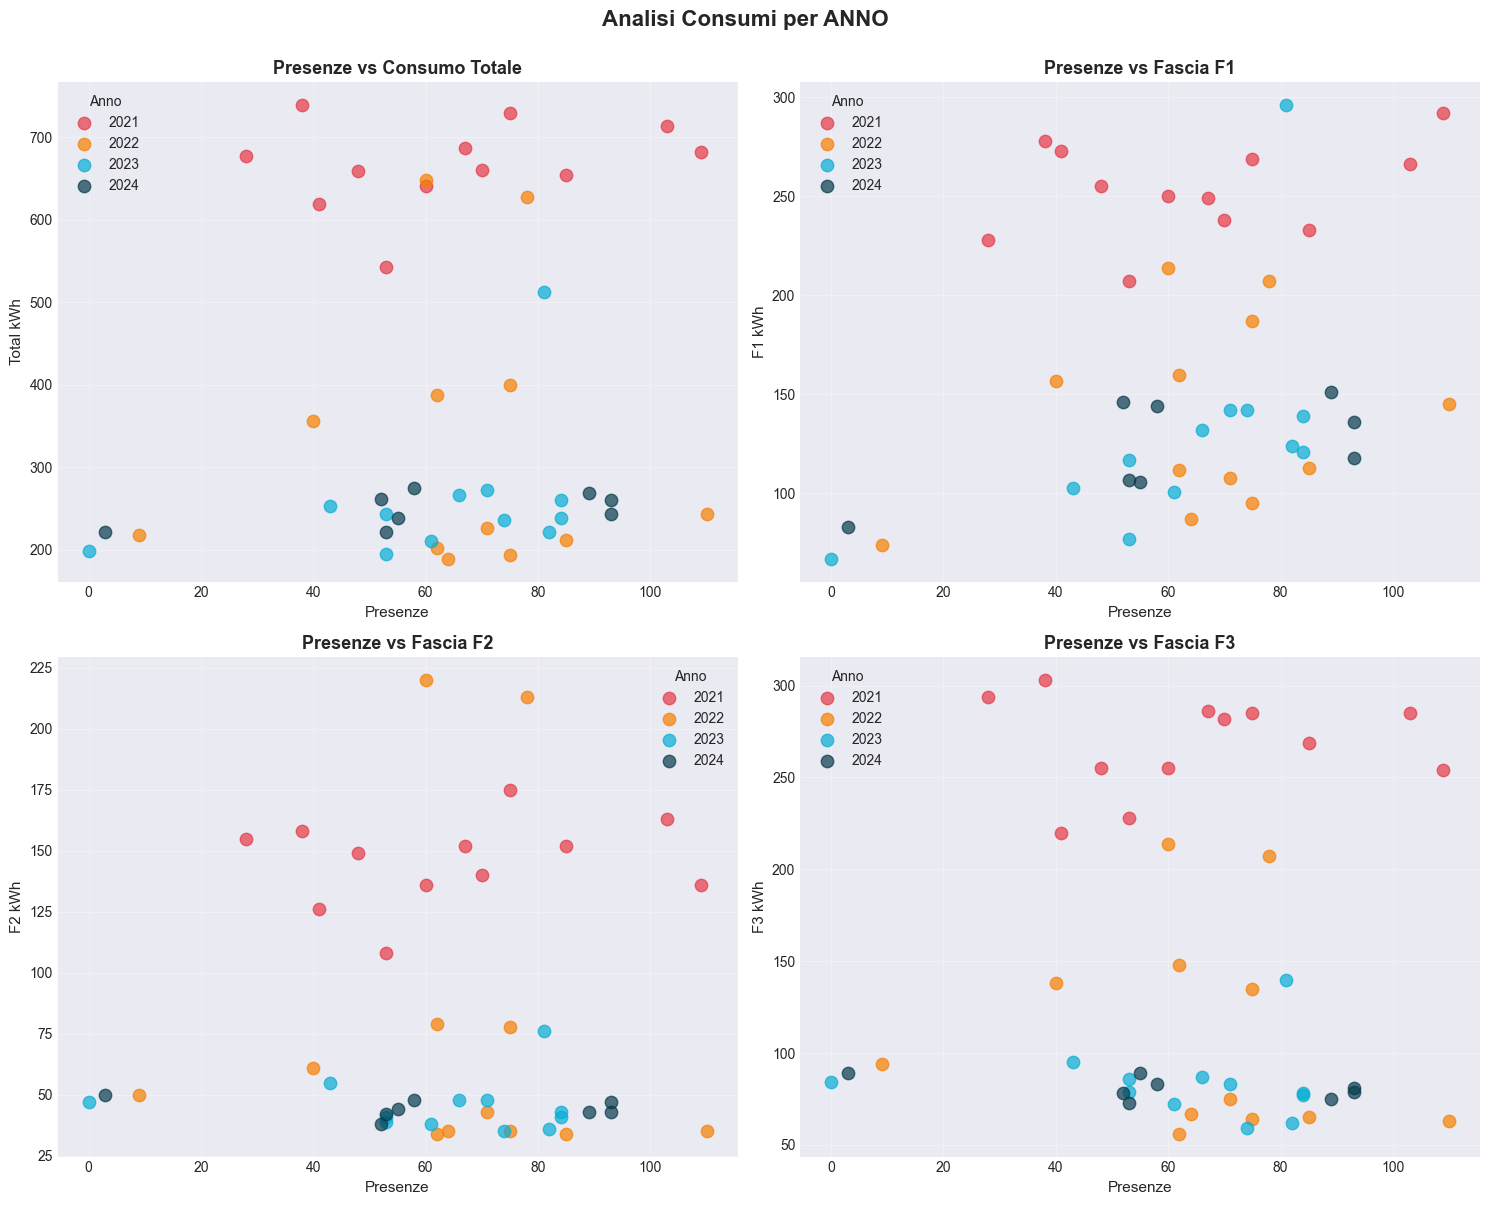

In [28]:
# Scatter Plot con colorazione per ANNO
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Definire colori per anno
colors_year = {2021: '#E63946', 2022: '#F77F00', 2023: '#06AED5', 2024: '#073B4C'}
years = df['anno'].unique()

# Presenze vs Total
for year in years:
    mask = df['anno'] == year
    axes[0, 0].scatter(df[mask]['presenze'], df[mask]['total_kWh'], 
                       alpha=0.7, s=80, color=colors_year[year], label=str(year))
axes[0, 0].set_title('Presenze vs Consumo Totale', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Presenze', fontsize=11)
axes[0, 0].set_ylabel('Total kWh', fontsize=11)
axes[0, 0].legend(title='Anno')
axes[0, 0].grid(True, alpha=0.3)

# Presenze vs F1
for year in years:
    mask = df['anno'] == year
    axes[0, 1].scatter(df[mask]['presenze'], df[mask]['f1_kWh'], 
                       alpha=0.7, s=80, color=colors_year[year], label=str(year))
axes[0, 1].set_title('Presenze vs Fascia F1', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Presenze', fontsize=11)
axes[0, 1].set_ylabel('F1 kWh', fontsize=11)
axes[0, 1].legend(title='Anno')
axes[0, 1].grid(True, alpha=0.3)

# Presenze vs F2
for year in years:
    mask = df['anno'] == year
    axes[1, 0].scatter(df[mask]['presenze'], df[mask]['f2_kWh'], 
                       alpha=0.7, s=80, color=colors_year[year], label=str(year))
axes[1, 0].set_title('Presenze vs Fascia F2', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Presenze', fontsize=11)
axes[1, 0].set_ylabel('F2 kWh', fontsize=11)
axes[1, 0].legend(title='Anno')
axes[1, 0].grid(True, alpha=0.3)

# Presenze vs F3
for year in years:
    mask = df['anno'] == year
    axes[1, 1].scatter(df[mask]['presenze'], df[mask]['f3_kWh'], 
                       alpha=0.7, s=80, color=colors_year[year], label=str(year))
axes[1, 1].set_title('Presenze vs Fascia F3', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Presenze', fontsize=11)
axes[1, 1].set_ylabel('F3 kWh', fontsize=11)
axes[1, 1].legend(title='Anno')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Analisi Consumi per ANNO', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

Osservando gli Scatter Plot con colorazione dei punti per ANNO si evidenziano chiari Break Strutturali

**Consumo Totale:**
- 2021 (rosso): cluster superiore 500-740 kWh - regime ad alto consumo
- 2022 (arancione): transizione 190-650 kWh - anno ibrido con forte eterogeneità
- 2023-2024 (azzurro/blu scuro): cluster inferiore 190-280 kWh - nuovo regime a basso consumo (presenza di un outlier di circa 500 kWh)
- Riduzione media di circa il 65% tra 2021 e 2023-2024

**F1 (fascia oraria di punta):**
- 2021: 230-300 kWh
- 2023-2024: 50-100 kWh (presenza di un outlier di circa 300 kWh)
- Riduzione media di circa 50-60%

**F2 (fascia oraria intermedia):**
- 2021: 125-180 kWh
- 2022: 25-80 kWh (presenza di due outlier di circa 210 e 220 kWh)
- 2023-2024: 25-75 kWh
- Riduzione media di circa il 75%

**F3 (fascia oraria non di punta):**
- 2021: 220-305 kWh
- 2022: 50-150 kWh (presenza di due outlier di circa 205 e 210 kWh) 
- 2023-2024: 50-100 kWh (presenza di un outlier di circa 150 kWh)
- Riduzione media di circa il 70%

Interpretazioni:
- Il fatto che F2 e F3 abbiano subito riduzioni più drastiche di F1 è la prova definitiva che i consumi non sono collegati con lo smart working (altrimenti F1 calerebbe di più)
- Il 2022 sembra essere l'anno di transizione

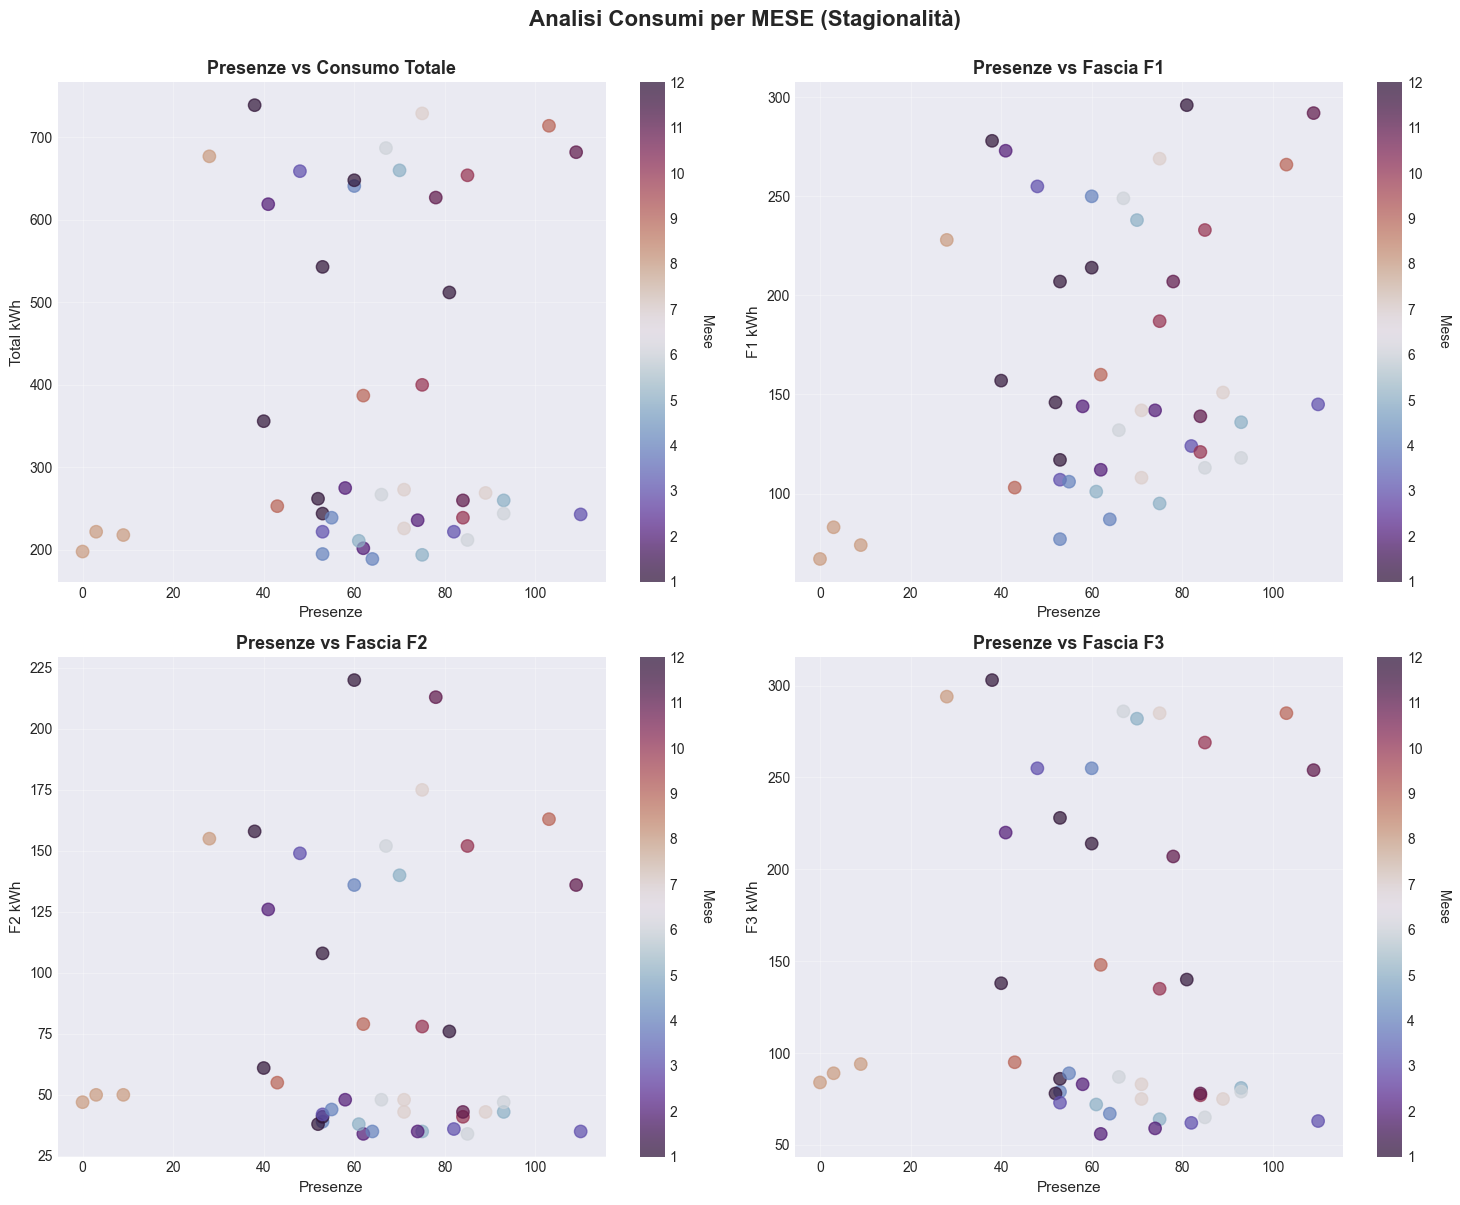

In [29]:
# Scatter Plot con colorazione per MESE (Stagionalità)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Definire colori per stagioni
import matplotlib.cm as cm

# Creare colormap per i 12 mesi
cmap = cm.get_cmap('twilight_shifted', 12)
colors_month = {i: cmap(i/12) for i in range(1, 13)}

# Nomi mesi per legenda
month_names = {1: 'Gen', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'Mag', 6: 'Giu',
               7: 'Lug', 8: 'Ago', 9: 'Set', 10: 'Ott', 11: 'Nov', 12: 'Dic'}

# Presenze vs Total
scatter1 = axes[0, 0].scatter(df['presenze'], df['total_kWh'], 
                              c=df['mese'], cmap='twilight_shifted', 
                              alpha=0.7, s=80, vmin=1, vmax=12)
axes[0, 0].set_title('Presenze vs Consumo Totale', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Presenze', fontsize=11)
axes[0, 0].set_ylabel('Total kWh', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0], ticks=range(1, 13))
cbar1.set_label('Mese', rotation=270, labelpad=20)

# Presenze vs F1
scatter2 = axes[0, 1].scatter(df['presenze'], df['f1_kWh'], 
                              c=df['mese'], cmap='twilight_shifted', 
                              alpha=0.7, s=80, vmin=1, vmax=12)
axes[0, 1].set_title('Presenze vs Fascia F1', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Presenze', fontsize=11)
axes[0, 1].set_ylabel('F1 kWh', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[0, 1], ticks=range(1, 13))
cbar2.set_label('Mese', rotation=270, labelpad=20)

# Presenze vs F2
scatter3 = axes[1, 0].scatter(df['presenze'], df['f2_kWh'], 
                              c=df['mese'], cmap='twilight_shifted', 
                              alpha=0.7, s=80, vmin=1, vmax=12)
axes[1, 0].set_title('Presenze vs Fascia F2', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Presenze', fontsize=11)
axes[1, 0].set_ylabel('F2 kWh', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=axes[1, 0], ticks=range(1, 13))
cbar3.set_label('Mese', rotation=270, labelpad=20)

# Presenze vs F3
scatter4 = axes[1, 1].scatter(df['presenze'], df['f3_kWh'], 
                              c=df['mese'], cmap='twilight_shifted', 
                              alpha=0.7, s=80, vmin=1, vmax=12)
axes[1, 1].set_title('Presenze vs Fascia F3', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Presenze', fontsize=11)
axes[1, 1].set_ylabel('F3 kWh', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)
cbar4 = plt.colorbar(scatter4, ax=axes[1, 1], ticks=range(1, 13))
cbar4.set_label('Mese', rotation=270, labelpad=20)

plt.suptitle('Analisi Consumi per MESE (Stagionalità)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

Gli Scatter Plot con colorazione dei punti per MESE non sembrano aggiungere altre informazioni rilevanti rispetto a quanto osservato finora.

## 📉 8. DECOMPOSIZIONE SERIE TEMPORALE

In [30]:
# Impostare l'indice come data per la decomposizione
df_ts = df.set_index('data')

# Decomposizione serie temporale sul consumo totale usando il modello additivo e un periodo di 12 mesi
decomposition_total = seasonal_decompose(df_ts['total_kWh'], model='additive', period=12)

Questa funzione (da statsmodels) decompone la serie usando il modello additivo:

**Y(t) = T(t) + S(t) + R(t)**

Dove:
- Y(t) = Serie osservata (consumo totale)
- T(t) = Componente di Trend (andamento di lungo periodo)
- S(t) = Componente Stagionale (pattern ripetitivi)
- R(t) = Residui (componente irregolare/rumore)

Il parametro period=12 indica stagionalità mensile 

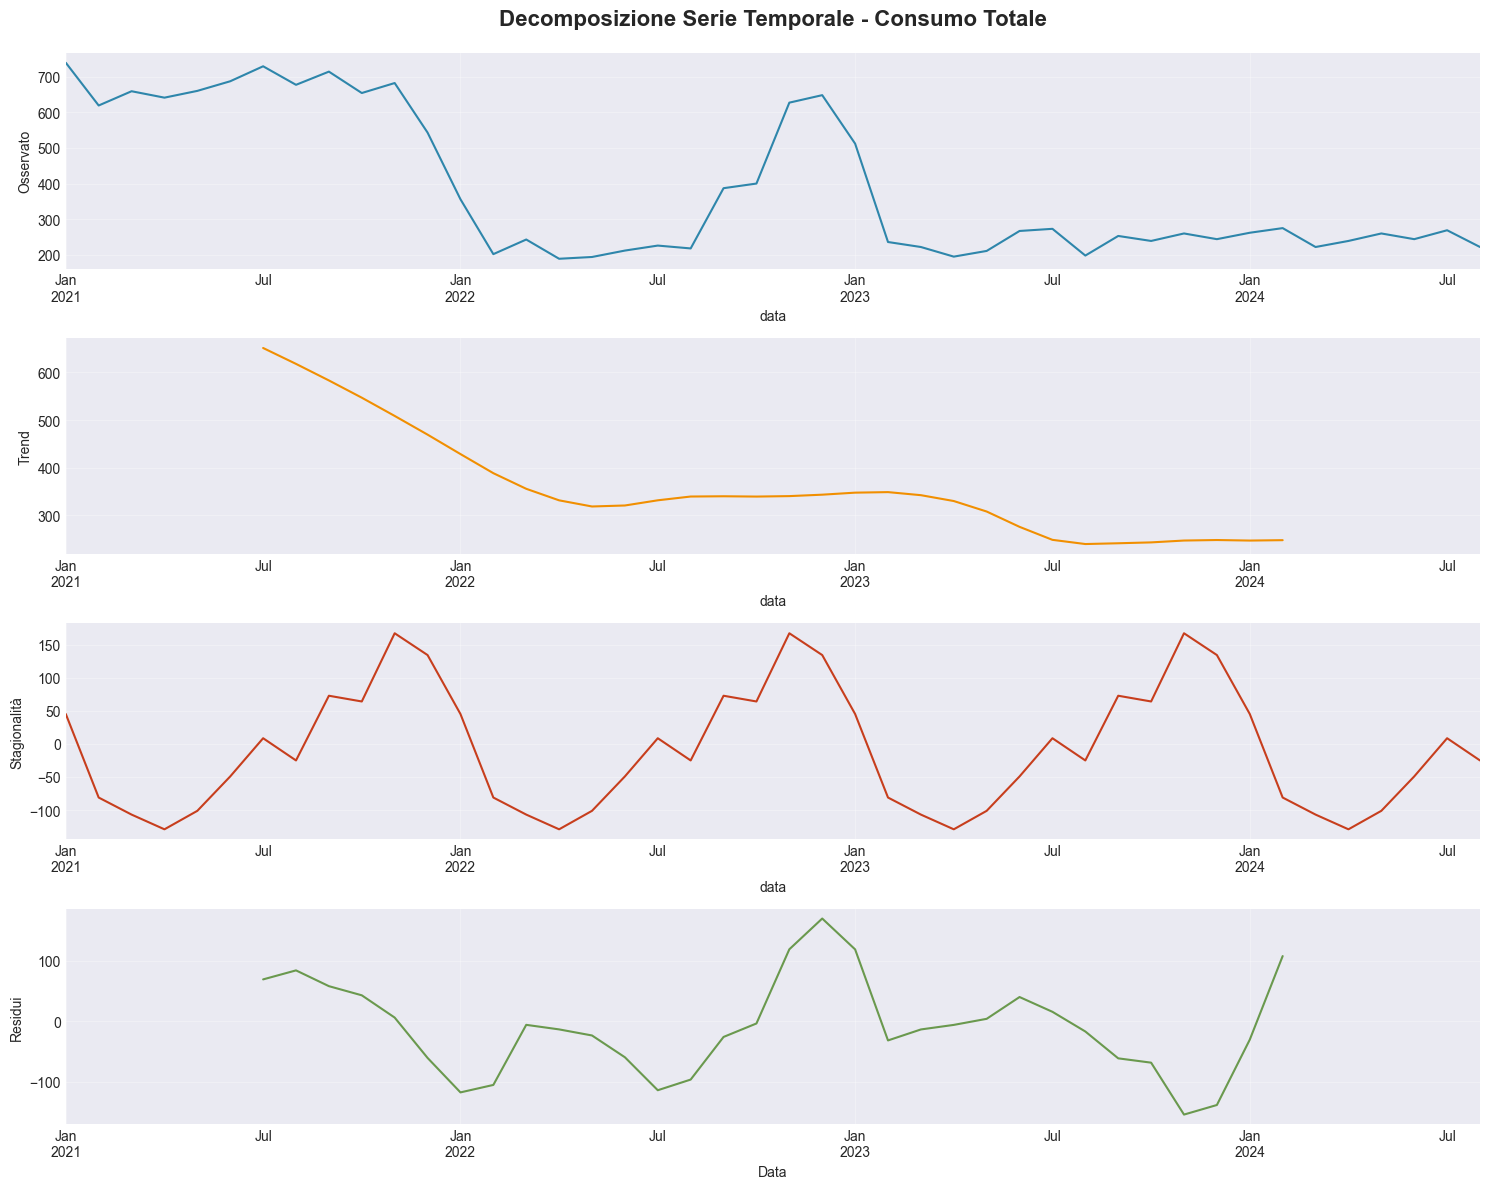

In [31]:
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Observed
decomposition_total.observed.plot(ax=axes[0], color='#2E86AB')
axes[0].set_ylabel('Osservato')
axes[0].set_title('Decomposizione Serie Temporale - Consumo Totale', fontsize=16, fontweight='bold', pad=20)
axes[0].grid(True, alpha=0.3)

# Trend
decomposition_total.trend.plot(ax=axes[1], color='#F18F01')
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

# Seasonal
decomposition_total.seasonal.plot(ax=axes[2], color='#C73E1D')
axes[2].set_ylabel('Stagionalità')
axes[2].grid(True, alpha=0.3)

# Residual
decomposition_total.resid.plot(ax=axes[3], color='#6A994E')
axes[3].set_ylabel('Residui')
axes[3].set_xlabel('Data')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Dai grafici di decomposizione possiamo trarre alcune osservazioni.

**Grafico 1: Serie Osservata**
- Mostra i dati reali di consumo elettrico
- Si notra un forte calo a fine 2021/inizio 2022: Break strutturale già osservato
- Picco anomalo tra fine 2022 e inizio 2023
- Dal 2023 il consumo di stabilizza su valori più bassi

**Grafico 2: Trend**
- Estrae l'andamento di lungo periodo eliminando fluttuazioni stagionali e rumore
- Si mostra chiaramente un trend discendente dal 2021 al 2022
- Una stabilizzazione di consumi su livelli inferiori dal 2022 in poi
- Una possibile ulteriore diminuzione negli anni successivi

**Grafico 3: Stagionalità**
- Mostra il pattern ripetitivo annuale
- Oscillazione regolari
- Pattern ciclico chiaro:
   - Picchi positivi (maggior consumo) in inverno
   - Minimi negativi (minor consumo) in estate
- Il pattern si ripete identicamente ogni anno (tipico comportamento stagionale dei consumi elettrici)

**Grafico 4: Residui**
- Rappresenta la componente irregolare/casuale (eventi non spiegabili da trend o stagionalità come guasti, condizioni meteorologiche estreme o eventi eccezionali)
- Picchi anomali visibili come a fine 2022 e inizio 2023 dove si registrano dei residui molto elevati

### DECOMPOSIZIONE SERIE TEMPORALE STL + DIAGNOSTICA RESIDUI COMPLETA

In [32]:
# Informazioni dataset
n_obs = len(df_ts)
date_start = df_ts.index.min()
date_end = df_ts.index.max()

print(f"   ✓ Dataset caricato")
print(f"   • Osservazioni totali: {n_obs}")
print(f"   • Periodo: {date_start.strftime('%b %Y')} - {date_end.strftime('%b %Y')}")
print(f"   • Frequenza: Mensile")
print(f"   • Variabile: total_kWh")

   ✓ Dataset caricato
   • Osservazioni totali: 44
   • Periodo: Jan 2021 - Aug 2024
   • Frequenza: Mensile
   • Variabile: total_kWh


#### Confronto tra modelli di decomposizione per l'analisi sui residui

In [33]:
print("\n🔄 Metodo 1: seasonal_decompose con estrapolazione")

decomp_classic = seasonal_decompose(
    df_ts['total_kWh'], 
    model='additive', 
    period=12,
    extrapolate_trend='freq'  # Recupera osservazioni perse
)

residui_classic = decomp_classic.resid.dropna()
n_obs_classic = len(residui_classic)

print(f"   ✓ Decomposizione completata")
print(f"   • Osservazioni nei residui: {n_obs_classic}")
print(f"   • Osservazioni perse: {n_obs - n_obs_classic}")


🔄 Metodo 1: seasonal_decompose con estrapolazione
   ✓ Decomposizione completata
   • Osservazioni nei residui: 44
   • Osservazioni perse: 0


In [34]:
print("\n🔄 Metodo 2: STL (decomposizione Seasonal-Trend usando regressione locale LOESS)")

stl = STL(
    df_ts['total_kWh'], 
    seasonal=13,      # Deve essere dispari; 13 è ottimale per period=12
    trend=None,       # Automatico (circa 1.5 * period)
    robust=True       # Robusto agli outliers
)

decomp_stl = stl.fit()

residui_stl = decomp_stl.resid
n_obs_stl = len(residui_stl)

print(f"   ✓ Decomposizione completata")
print(f"   • Osservazioni nei residui: {n_obs_stl}")
print(f"   • Osservazioni perse: {n_obs - n_obs_stl}")

print("\n✅ SCELTA METODO: STL (mantiene tutte le osservazioni)")

# Usa STL per analisi successive
decomposition_total = decomp_stl


🔄 Metodo 2: STL (decomposizione Seasonal-Trend usando regressione locale LOESS)
   ✓ Decomposizione completata
   • Osservazioni nei residui: 44
   • Osservazioni perse: 0

✅ SCELTA METODO: STL (mantiene tutte le osservazioni)


#### Diagnostica residui - visualizzazione grafica

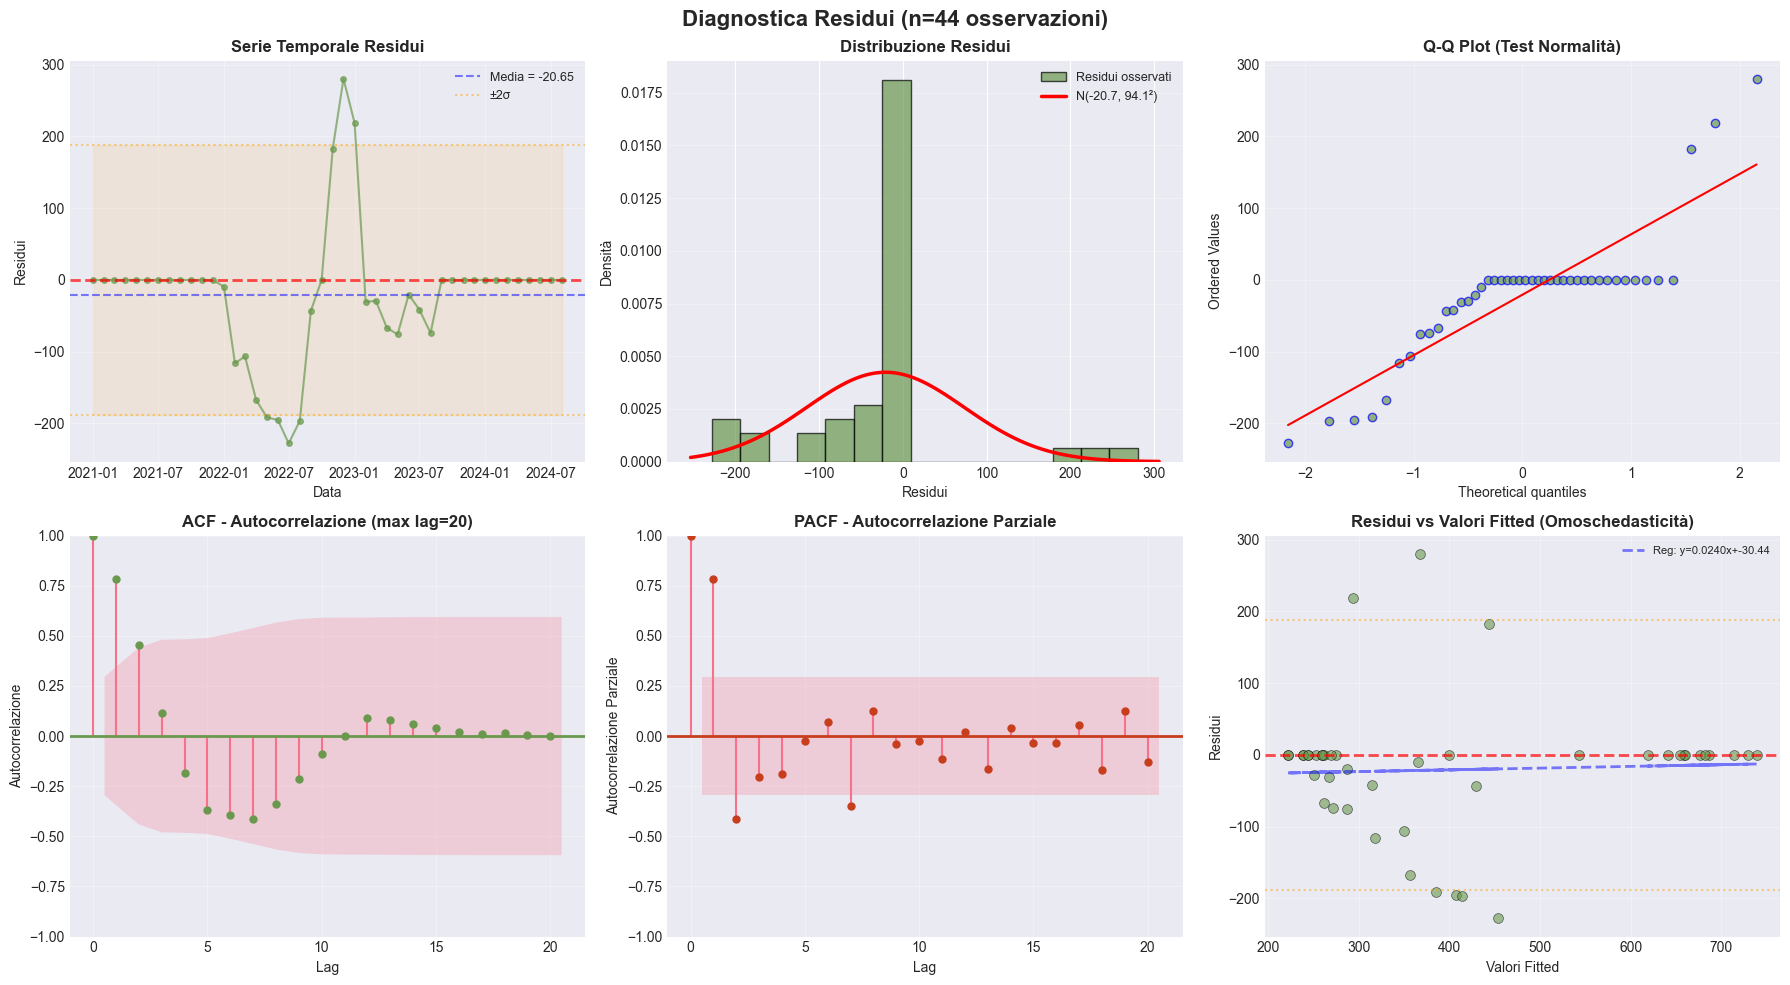

In [35]:
residui = decomposition_total.resid
n = len(residui)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Diagnostica Residui (n={n} osservazioni)', 
             fontsize=16, fontweight='bold')

# Serie temporale dei residui
axes[0, 0].plot(df_ts.index, residui, color='#6A994E', linewidth=1.5, 
                marker='o', markersize=4, alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
axes[0, 0].axhline(y=residui.mean(), color='blue', linestyle='--', alpha=0.5, 
                   linewidth=1.5, label=f'Media = {residui.mean():.2f}')
# Bande ±2σ
std_residui = residui.std()
axes[0, 0].axhline(y=2*std_residui, color='orange', linestyle=':', alpha=0.5, 
                   label='±2σ')
axes[0, 0].axhline(y=-2*std_residui, color='orange', linestyle=':', alpha=0.5)
axes[0, 0].fill_between(df_ts.index, -2*std_residui, 2*std_residui, 
                        alpha=0.1, color='orange')

axes[0, 0].set_title('Serie Temporale Residui', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Data', fontsize=10)
axes[0, 0].set_ylabel('Residui', fontsize=10)
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# Istogramma + curva normale
axes[0, 1].hist(residui, bins=15, density=True, alpha=0.7, color='#6A994E', 
                edgecolor='black', label='Residui osservati')

# Sovrapporre distribuzione normale teorica
mu, sigma = residui.mean(), residui.std()
xmin, xmax = axes[0, 1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
axes[0, 1].plot(x, p, 'r-', linewidth=2.5, label=f'N({mu:.1f}, {sigma:.1f}²)')

axes[0, 1].set_title('Distribuzione Residui', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Residui', fontsize=10)
axes[0, 1].set_ylabel('Densità', fontsize=10)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Q-Q Plot (normalità)
stats.probplot(residui, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot (Test Normalità)', fontweight='bold', fontsize=12)
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].get_lines()[0].set_markerfacecolor('#6A994E')
axes[0, 2].get_lines()[0].set_markersize(6)
axes[0, 2].get_lines()[0].set_alpha(0.7)

#ACF - Funzione di autocorrelazione
max_lags = min(20, n//2 - 1)
plot_acf(residui, lags=max_lags, ax=axes[1, 0], alpha=0.05, 
         color='#6A994E', lw=2)
axes[1, 0].set_title(f'ACF - Autocorrelazione (max lag={max_lags})', 
                     fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Lag', fontsize=10)
axes[1, 0].set_ylabel('Autocorrelazione', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# PACF - Funzione di autocorrelazione parziale
plot_pacf(residui, lags=max_lags, ax=axes[1, 1], alpha=0.05, 
          color='#C73E1D', lw=2, method='ywm')
axes[1, 1].set_title(f'PACF - Autocorrelazione Parziale', 
                     fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Lag', fontsize=10)
axes[1, 1].set_ylabel('Autocorrelazione Parziale', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# Residui vs Valori Fitted
fitted = decomposition_total.trend + decomposition_total.seasonal
axes[1, 2].scatter(fitted, residui, alpha=0.6, color='#6A994E', s=50, 
                   edgecolor='black', linewidth=0.5)
axes[1, 2].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
axes[1, 2].axhline(y=2*std_residui, color='orange', linestyle=':', alpha=0.5)
axes[1, 2].axhline(y=-2*std_residui, color='orange', linestyle=':', alpha=0.5)

# Linea di regressione (dovrebbe essere piatta)
z = np.polyfit(fitted, residui, 1)
p = np.poly1d(z)
axes[1, 2].plot(fitted, p(fitted), "b--", alpha=0.5, linewidth=2, 
                label=f'Reg: y={z[0]:.4f}x+{z[1]:.2f}')

axes[1, 2].set_title('Residui vs Valori Fitted (Omoschedasticità)', 
                     fontweight='bold', fontsize=12)
axes[1, 2].set_xlabel('Valori Fitted', fontsize=10)
axes[1, 2].set_ylabel('Residui', fontsize=10)
axes[1, 2].legend(fontsize=8)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Problemi Identificati:**
1. ❌ Violazione dell'assunzione di normalità (code pesanti, outlier)
2. ❌ Eteroschedasticità (varianza non costante)
3. ❌ Autocorrelazione significativa (modello di decomposizione incompleto)
4. ❌ Presenza di outlier estremi (ottobre 2022)

Il modello di decomposizione provato non è adeguato perché i residui mostrano pattern sistematici (autocorrelazione) e vi è presenza di eteroschedasticità.

Come next steps si valuterà modello SARIMA invece della semplice decomposizione, oltre che trasformare i dati (log oppure Box-Cox)

## 📊 9. TEST DI STAZIONARIETÀ

### Test ADF (Augmented Dickey-Fuller) e KPSS

Si eseguono test ADF (Augmented Dickey-Fuller) e KPSS per verificare stazionarietà

In [36]:
def test_stationarity(timeseries, title):
# ADF Test
    adf_result = adfuller(timeseries.dropna(), autolag='AIC')
    print(f"\n📌 Augmented Dickey-Fuller Test:")
    print(f"   • Test Statistic: {adf_result[0]:.4f}")
    print(f"   • p-value: {adf_result[1]:.4f}")
    print(f"   • Critical Values:")
    for key, value in adf_result[4].items():
        print(f"      {key}: {value:.3f}")
    
    if adf_result[1] <= 0.05:
        print(f"   ✅ STAZIONARIA (p-value ≤ 0.05)")
    else:
        print(f"   ❌ NON STAZIONARIA (p-value > 0.05)")
# KPSS Test
    kpss_result = kpss(timeseries.dropna(), regression='c', nlags='auto')
    print(f"\n📌 KPSS Test:")
    print(f"   • Test Statistic: {kpss_result[0]:.4f}")
    print(f"   • p-value: {kpss_result[1]:.4f}")
    print(f"   • Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"      {key}: {value:.3f}")
    
    if kpss_result[1] >= 0.05:
        print(f"   ✅ STAZIONARIA (p-value ≥ 0.05)")
    else:
        print(f"   ❌ NON STAZIONARIA (p-value < 0.05)")
    print()

In [37]:
# Test su presenze
test_stationarity(df_ts['presenze'], "presenze")


📌 Augmented Dickey-Fuller Test:
   • Test Statistic: -3.7627
   • p-value: 0.0033
   • Critical Values:
      1%: -3.610
      5%: -2.939
      10%: -2.608
   ✅ STAZIONARIA (p-value ≤ 0.05)

📌 KPSS Test:
   • Test Statistic: 0.0938
   • p-value: 0.1000
   • Critical Values:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ✅ STAZIONARIA (p-value ≥ 0.05)



In [38]:
# Test su consumi totali
test_stationarity(df_ts['total_kWh'], "consumo Totale")


📌 Augmented Dickey-Fuller Test:
   • Test Statistic: -2.2453
   • p-value: 0.1902
   • Critical Values:
      1%: -3.601
      5%: -2.935
      10%: -2.606
   ❌ NON STAZIONARIA (p-value > 0.05)

📌 KPSS Test:
   • Test Statistic: 0.6242
   • p-value: 0.0204
   • Critical Values:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ❌ NON STAZIONARIA (p-value < 0.05)



I risultati sul test di stazionarietà dei consumi totali mostrano chiaramente che la serie temporale non è stazionaria. Entrambi i test concordano. 

#### Alcune tecniche per rendere la serie stazionaria sono:

In [39]:
# 1. Differenziazione

# Prima differenza
df_ts['total_kWh_diff'] = df_ts['total_kWh'].diff()

# Testa la serie differenziata
test_stationarity(df_ts['total_kWh_diff'], "Consumo Totale - Differenziato")


📌 Augmented Dickey-Fuller Test:
   • Test Statistic: -5.1755
   • p-value: 0.0000
   • Critical Values:
      1%: -3.597
      5%: -2.933
      10%: -2.605
   ✅ STAZIONARIA (p-value ≤ 0.05)

📌 KPSS Test:
   • Test Statistic: 0.0694
   • p-value: 0.1000
   • Critical Values:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ✅ STAZIONARIA (p-value ≥ 0.05)



In [40]:
# 2. Differenziazione stagionale (dato che la serie possiede stagionalità)

df_ts['total_kWh_seasonal_diff'] = df_ts['total_kWh'].diff(12)

test_stationarity(df_ts['total_kWh_seasonal_diff'], "Consumo - Diff Stagionale (12 mesi)")


📌 Augmented Dickey-Fuller Test:
   • Test Statistic: -1.3937
   • p-value: 0.5853
   • Critical Values:
      1%: -3.788
      5%: -3.013
      10%: -2.646
   ❌ NON STAZIONARIA (p-value > 0.05)

📌 KPSS Test:
   • Test Statistic: 0.4212
   • p-value: 0.0680
   • Critical Values:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ✅ STAZIONARIA (p-value ≥ 0.05)



In [41]:
# 3. Doppia Differenziazione (trend + stagionalità)

# Prima rimuovi la stagionalità, poi il trend
df_ts['total_kWh_double_diff'] = df_ts['total_kWh'].diff(12).diff()

test_stationarity(df_ts['total_kWh_double_diff'], "Consumo - Doppia Differenziazione")


📌 Augmented Dickey-Fuller Test:
   • Test Statistic: -2.6620
   • p-value: 0.0808
   • Critical Values:
      1%: -3.788
      5%: -3.013
      10%: -2.646
   ❌ NON STAZIONARIA (p-value > 0.05)

📌 KPSS Test:
   • Test Statistic: 0.0680
   • p-value: 0.1000
   • Critical Values:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ✅ STAZIONARIA (p-value ≥ 0.05)



In [42]:
# 4. Trasformazione Logaritmica + Differenziazione

# Log transform (stabilizza la varianza)
df_ts['log_kWh'] = np.log(df_ts['total_kWh'] + 1)
df_ts['log_kWh_diff'] = df_ts['log_kWh'].diff()

test_stationarity(df_ts['log_kWh_diff'], "Log Consumo - Differenziato")


📌 Augmented Dickey-Fuller Test:
   • Test Statistic: -5.6861
   • p-value: 0.0000
   • Critical Values:
      1%: -3.597
      5%: -2.933
      10%: -2.605
   ✅ STAZIONARIA (p-value ≤ 0.05)

📌 KPSS Test:
   • Test Statistic: 0.0571
   • p-value: 0.1000
   • Critical Values:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ✅ STAZIONARIA (p-value ≥ 0.05)



In [43]:
# 5. Detrending

from scipy import signal

# Rimuovi il trend lineare
detrended = signal.detrend(df_ts['total_kWh'].dropna())
df_ts_detrended = pd.Series(detrended, index=df_ts['total_kWh'].dropna().index)

test_stationarity(df_ts_detrended, "Consumo Detrended")


📌 Augmented Dickey-Fuller Test:
   • Test Statistic: -3.3405
   • p-value: 0.0132
   • Critical Values:
      1%: -3.621
      5%: -2.944
      10%: -2.610
   ✅ STAZIONARIA (p-value ≤ 0.05)

📌 KPSS Test:
   • Test Statistic: 0.1036
   • p-value: 0.1000
   • Critical Values:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ✅ STAZIONARIA (p-value ≥ 0.05)



In [44]:
import numpy as np
from scipy import signal

# Funzione per testare multiple trasformazioni
def test_all_transformations(series, name):
    transformations = {}
    
    # 1. Differenziazione semplice
    transformations['Diff (1)'] = series.diff()
    
    # 2. Differenziazione stagionale
    if len(series) >= 12:
        transformations['Diff Stagionale (12)'] = series.diff(12)
    
    # 3. Doppia differenziazione
    if len(series) >= 13:
        transformations['Doppia Diff (12,1)'] = series.diff(12).diff()
    
    # 4. Log + Diff
    transformations['Log + Diff'] = np.log(series + 1).diff()
    
    # 5. Detrending
    detrended = signal.detrend(series.dropna())
    transformations['Detrended'] = pd.Series(detrended, index=series.dropna().index)
    
    # Testa tutte le trasformazioni
    print(f"{'='*70}")
    print(f"🔍 TEST STAZIONARIETÀ PER: {name}")
    print(f"{'='*70}\n")
    
    for trans_name, trans_series in transformations.items():
        print(f"\n{'─'*70}")
        print(f"📊 TRASFORMAZIONE: {trans_name}")
        print(f"{'─'*70}")
        test_stationarity(trans_series, trans_name)

# Esegui i test
test_all_transformations(df_ts['total_kWh'], "Consumo Totale Mensile")

🔍 TEST STAZIONARIETÀ PER: Consumo Totale Mensile


──────────────────────────────────────────────────────────────────────
📊 TRASFORMAZIONE: Diff (1)
──────────────────────────────────────────────────────────────────────

📌 Augmented Dickey-Fuller Test:
   • Test Statistic: -5.1755
   • p-value: 0.0000
   • Critical Values:
      1%: -3.597
      5%: -2.933
      10%: -2.605
   ✅ STAZIONARIA (p-value ≤ 0.05)

📌 KPSS Test:
   • Test Statistic: 0.0694
   • p-value: 0.1000
   • Critical Values:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ✅ STAZIONARIA (p-value ≥ 0.05)


──────────────────────────────────────────────────────────────────────
📊 TRASFORMAZIONE: Diff Stagionale (12)
──────────────────────────────────────────────────────────────────────

📌 Augmented Dickey-Fuller Test:
   • Test Statistic: -1.3937
   • p-value: 0.5853
   • Critical Values:
      1%: -3.788
      5%: -3.013
      10%: -2.646
   ❌ NON STAZIONARIA (p-value > 0.05)

📌 KPSS Test:
   • Test S

### Analisi dei risultati dei test di stazionarietà

| Trasformazione | ADF Test | KPSS Test | Verdetto Finale |
|---|---|---|---|
| Diff (1) | ✅ Stazionaria | ✅ Stazionaria | ✅ STAZIONARIA |
| Diff Stagionale (12) | ❌ Non stazionaria | ✅ Stazionaria | ❌ Non stazionaria |
| Doppia Diff (12,1) | ❌ Non stazionaria* | ✅ Stazionaria | ⚠️ Borderline |
| Log + Diff | ✅ Stazionaria | ✅ Stazionaria | ✅ STAZIONARIA |
| Detrended | ✅ Stazionaria | ✅ Stazionaria | ✅ STAZIONARIA |

Dai risultati ottenuti riscontriamo che il problema principale era il TREND, non la stagionalità. 

Infatti la differenziazione stagionale (12 mesi) da sola non è bastata, quindi sui nostri dati abbiamo poca evidenza di stagionalità annuale forte. 

Una semplice differenza invece risolve il problema e rende la serie stazionaria.

Per la modellazione quindi sarà consigliato usare la differenziazione oppure la log-differenziazione:

Opzione 1: Serie differenziata semplice
- serie_modeling = df_ts['total_kWh'].diff().dropna()

Opzione 2: Serie log-differenziata (migliore se varianza aumenta nel tempo)
- serie_modeling = np.log(df_ts['total_kWh'] + 1).diff().dropna()

Poi quando si svolgono le previsioni con ARIMA:
- Con Diff(1) si userà il parametro d=1
- Con Log+Diff si trasformerà i dati in log, poi si userà d=1, infine con exp() per le previsioni con valori originali e interpretabili

N.B: SARIMA e Prophet usano iperparametri per la tendenza e la stagionalità, in modo che la serie non debba essere stazionaria.

## 📈 10. ACF e PACF

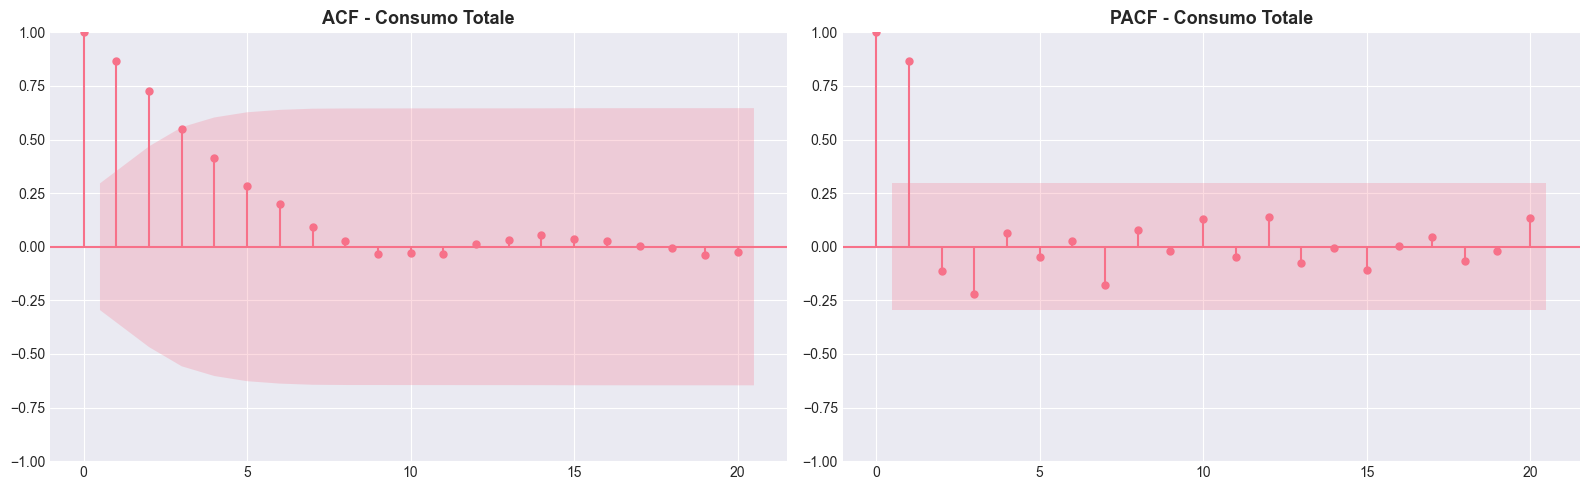

In [48]:
# Plot ACF e PACF per Consumo Totale
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF - Consumo Totale
plot_acf(df_ts['total_kWh'].dropna(), lags=20, ax=axes[0])
axes[0].set_title('ACF - Consumo Totale', fontsize=13, fontweight='bold')

# PACF - Consumo Totale
plot_pacf(df_ts['total_kWh'].dropna(), lags=20, ax=axes[1])
axes[1].set_title('PACF - Consumo Totale', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

Questi grafici confermano l'analisi precedente e ci danno informazioni preziose per la modellazione ARIMA.

**ACF - Consumo Totale**
- Decadimento lento e graduale dei lag (da 1.0 → 0.9 → 0.75 → ...)
- I valori rimangono significativi (fuori dalla banda azzurra) per molti lag
- ✅ Questo conferma la NON STAZIONARIETÀ e la presenza di TREND

**PACF - Consumo Totale**
- Primo lag molto significativo (≈0.9)
- Dopo il lag 1, i valori oscillano attorno a 0 (dentro la banda)
- ✅ Pattern tipico di una serie con trend → serve differenziazione

## 🎯 11. OUTLIER DETECTION

In [49]:
# Identifica outlier con metodo IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


📊 total_kWh:
   • Limite inferiore: -383.25
   • Limite superiore: 1238.75
   • Outlier trovati: 0

📊 f1_kWh:
   • Limite inferiore: -66.38
   • Limite superiore: 406.62
   • Outlier trovati: 0

📊 f2_kWh:
   • Limite inferiore: -101.50
   • Limite superiore: 278.50
   • Outlier trovati: 0

📊 f3_kWh:
   • Limite inferiore: -141.75
   • Limite superiore: 440.25
   • Outlier trovati: 0

📊 presenze:
   • Limite inferiore: 10.62
   • Limite superiore: 123.62
   • Outlier trovati: 3
   • Date con outlier: ['2022-08', '2023-08', '2024-08']


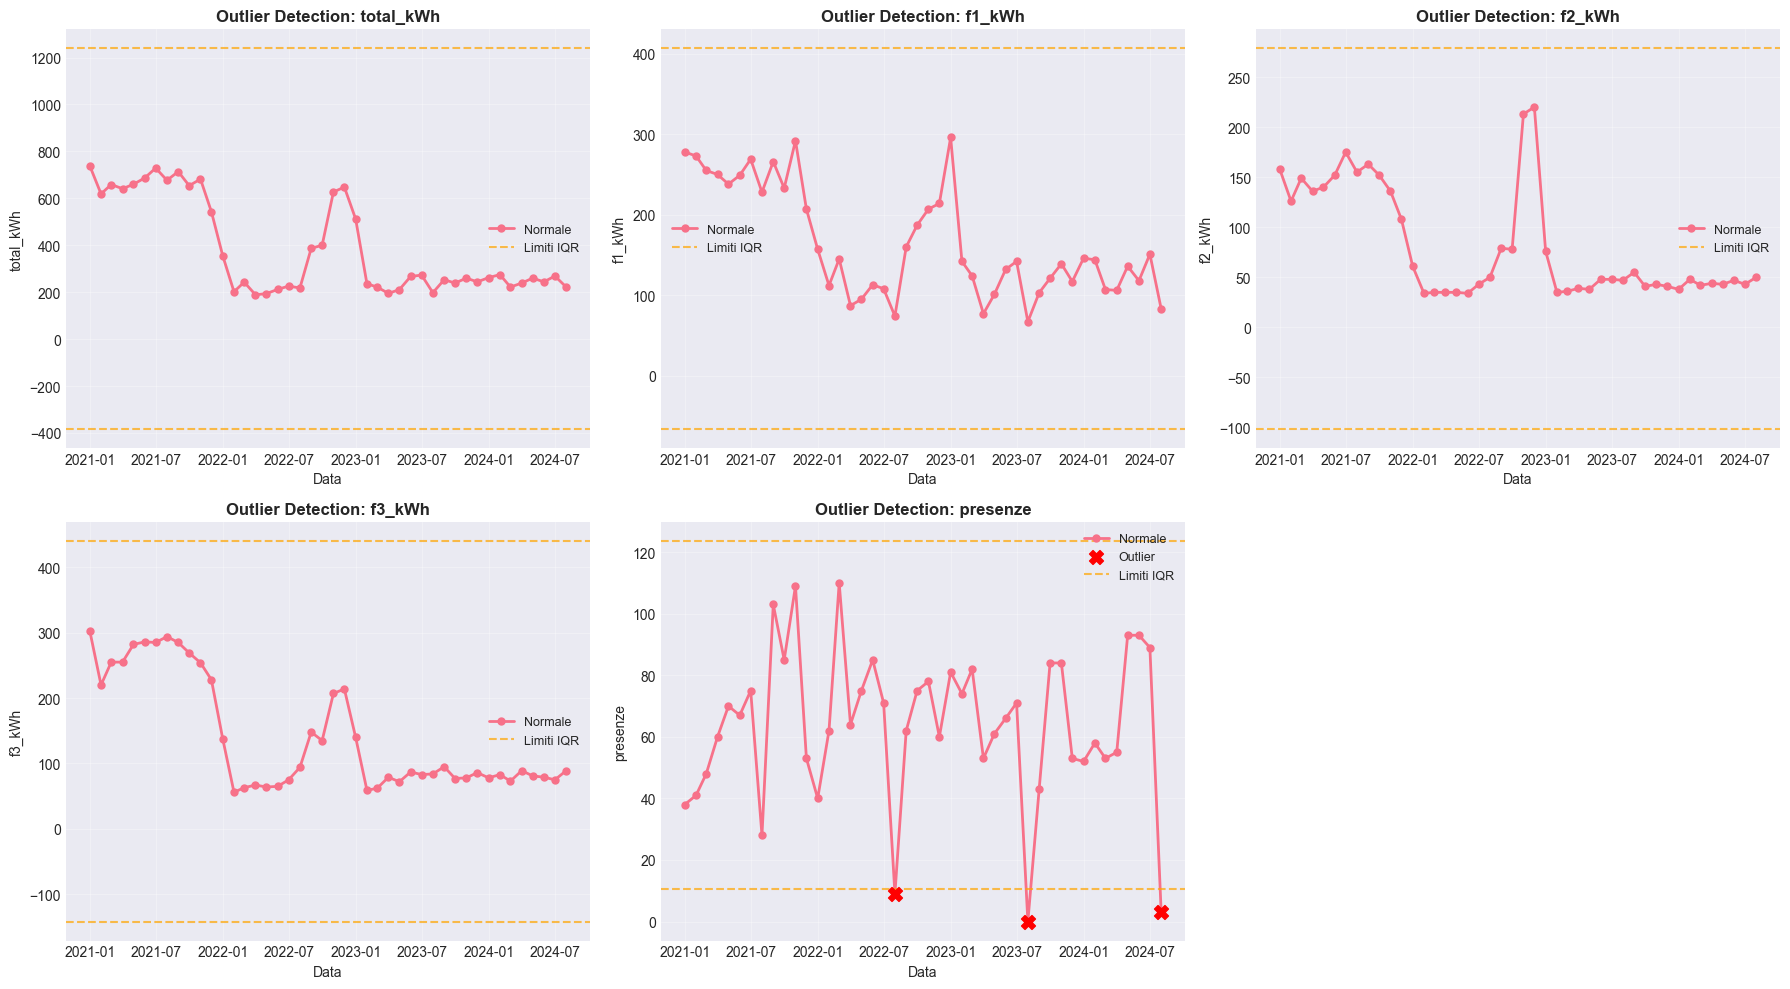

In [50]:
for col in ['total_kWh', 'f1_kWh', 'f2_kWh', 'f3_kWh', 'presenze']:
    outliers, lb, ub = detect_outliers_iqr(df, col)
    print(f"\n📊 {col}:")
    print(f"   • Limite inferiore: {lb:.2f}")
    print(f"   • Limite superiore: {ub:.2f}")
    print(f"   • Outlier trovati: {len(outliers)}")
    
    if len(outliers) > 0:
        print(f"   • Date con outlier: {outliers['data'].dt.strftime('%Y-%m').tolist()}")

# %%
# Visualizza outlier
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, col in enumerate(['total_kWh', 'f1_kWh', 'f2_kWh', 'f3_kWh', 'presenze']):
    row = idx // 3
    col_idx = idx % 3
    
    outliers, lb, ub = detect_outliers_iqr(df, col)
    
    axes[row, col_idx].plot(df['data'], df[col], marker='o', linewidth=2, markersize=5, label='Normale')
    if len(outliers) > 0:
        axes[row, col_idx].scatter(outliers['data'], outliers[col], color='red', s=100, 
                                    zorder=5, label='Outlier', marker='X')
    axes[row, col_idx].axhline(lb, color='orange', linestyle='--', alpha=0.7, label='Limiti IQR')
    axes[row, col_idx].axhline(ub, color='orange', linestyle='--', alpha=0.7)
    axes[row, col_idx].set_title(f'Outlier Detection: {col}', fontsize=12, fontweight='bold')
    axes[row, col_idx].set_xlabel('Data')
    axes[row, col_idx].set_ylabel(col)
    axes[row, col_idx].legend(fontsize=9)
    axes[row, col_idx].grid(True, alpha=0.3)

# Rimuovi subplot vuoto
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

# 🤖 Modelli PredittivI

**Obiettivo:** Sviluppare e confrontare modelli di forecasting per prevedere i consumi energetici totali
 
**Modelli implementati:**
1. Baseline (Naive, Media Mobile)
2. SARIMA (Seasonal ARIMA)
3. Prophet (Facebook)
4. XGBoost (con feature engineering)
5. Ensemble SARIMA + XGBoost
6. Ensemble Prophet + XGBoost

## 📦 1. INSTALLAZIONE LIBRERIE

In [51]:
libraries = [
    'pmdarima',      # Auto ARIMA
    'prophet',       # Prophet
    'xgboost',       # XGBoost
    'plotly',        # Grafici interattivi
    'kaleido'        # Export grafici Plotly
]

**Eseguire questa cella UNA SOLA VOLTA per installare le librerie**
```
import sys
import subprocess

for lib in libraries:
    print(f"\n📥 Installazione {lib}...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", lib, "-q"])
        print(f"✅ {lib} installato con successo!")
    except Exception as e:
        print(f"❌ Errore installazione {lib}: {e}")
```
📥 Installazione pmdarima...

✅ pmdarima installato con successo!

📥 Installazione prophet...

✅ prophet installato con successo!

📥 Installazione xgboost...

✅ xgboost installato con successo!

📥 Installazione plotly...

✅ plotly installato con successo!

📥 Installazione kaleido...

✅ kaleido installato con successo!

## 📚 2. IMPORT LIBRERIE

In [52]:
# Visualizzazione
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Serie temporali - SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Prophet
from prophet import Prophet

# XGBoost
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# Metriche
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 🔧 3. PREPARAZIONE DATI & TRAIN/TEST SPLIT

In [53]:
# Crea dataset per time series
df_ts = df[['data', 'total_kWh']].copy()
df_ts = df_ts.set_index('data')
df_ts.index.freq = 'MS'  # Month Start frequency

In [54]:
# Split Train/Test (ultimi 3 mesi per test)
train_size = len(df_ts) - 3
train = df_ts.iloc[:train_size].copy()
test = df_ts.iloc[train_size:].copy()

In [55]:
print("=" * 70)
print("📊 TRAIN/TEST SPLIT")
print("=" * 70)
print(f"\n✅ Train set:")
print(f"   • Periodo: {train.index.min()} → {train.index.max()}")
print(f"   • N. osservazioni: {len(train)}")
print(f"\n✅ Test set:")
print(f"   • Periodo: {test.index.min()} → {test.index.max()}")
print(f"   • N. osservazioni: {len(test)}")

📊 TRAIN/TEST SPLIT

✅ Train set:
   • Periodo: 2021-01-01 00:00:00 → 2024-05-01 00:00:00
   • N. osservazioni: 41

✅ Test set:
   • Periodo: 2024-06-01 00:00:00 → 2024-08-01 00:00:00
   • N. osservazioni: 3


In [56]:
# Visualizza split
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=train.index, y=train['total_kWh'],
    mode='lines+markers',
    name='Training Set',
    line=dict(color='blue', width=2),
    marker=dict(size=6)
))

fig.add_trace(go.Scatter(
    x=test.index, y=test['total_kWh'],
    mode='lines+markers',
    name='Test Set',
    line=dict(color='red', width=2),
    marker=dict(size=8)
))

fig.update_layout(
    title='📊 Train/Test Split - Consumi Energetici',
    xaxis_title='Data',
    yaxis_title='Consumo (kWh)',
    height=500,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

### STAZIONARIETÀ NEI DIVERSI MODELLI

1. SARIMA ✅
- Gestisce automaticamente la non-stazionarietà tramite il parametro d (differenziazione)
- Auto ARIMA trova d ottimale
- ✅ Non serve pre-processare

2. Prophet ✅
- Gestisce intrinsecamente trend e stagionalità
- Decompone la serie in: trend + stagionalità + residui
- ✅ Non serve differenziare (lo fa internamente)

3. XGBoost ❌
- NON gestisce automaticamente la non-stazionarietà
- Lavora su features, non comprende la struttura temporale
- ⚠️ SERVE trasformare i dati!

## 📊 4. METRICHE DI VALUTAZIONE

### Perché non usare l’R² come metrica di valutazione per serie temporali

l’R² può essere negativo in un modello SARIMA

L’R² diventa **negativo** quando il modello sbaglia più di un modello banale che predice sempre la media storica della serie.

Interpretazione nel contesto delle serie temporali

Nel caso delle serie storiche dove si sta utilizzando un modello **SARIMA**:

- L’R² **non è una metrica ideale** per le serie temporali, perché non tiene conto della dipendenza temporale, della stagionalità e del trend.
- Un modello può:
  - prevedere correttamente la **direzione del cambiamento** (Directional Accuracy = 100%)
  - ma sbagliare la **magnitudine delle previsioni**. Questo genera errori quadratici elevati (SSE alta) e quindi un R² negativo.
- Se la varianza della serie nel periodo di test è bassa (SST piccola), anche errori moderati producono R² molto negativi.

**Metriche più adatte per time series**

Per le serie temporali sono generalmente preferibili:
- **MAE**
- **RMSE**
- **MAPE / sMAPE**
- **MASE**


In [57]:
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """
    Calcola metriche di performance per serie temporali
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Directional Accuracy (prevede correttamente la direzione?)
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    directional_acc = np.mean((y_true_diff * y_pred_diff) > 0) * 100
    
    metrics = {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'Dir. Acc. (%)': directional_acc
    }
    
    return metrics

In [58]:
def print_metrics(metrics):
    """
    Stampa metriche in formato leggibile
    """
    print("\n" + "=" * 70)
    print(f"📊 METRICHE - {metrics['Model']}")
    print("=" * 70)
    print(f"  • MAE:  {metrics['MAE']:.2f} kWh")
    print(f"  • RMSE: {metrics['RMSE']:.2f} kWh")
    print(f"  • MAPE: {metrics['MAPE (%)']:.2f}%")
    print(f"  • Directional Accuracy: {metrics['Dir. Acc. (%)']:.2f}%")
    print("=" * 70)

In [59]:
# Storage per tutte le metriche
all_metrics = []

## 📈 5. BASELINE MODELS

In [60]:
# Baseline 1: Naive (ultimo valore osservato)
naive_pred = [train['total_kWh'].iloc[-1]] * len(test)
metrics_naive = calculate_metrics(test['total_kWh'].values, naive_pred, "Naive (Last Value)")
all_metrics.append(metrics_naive)
print_metrics(metrics_naive)


📊 METRICHE - Naive (Last Value)
  • MAE:  21.00 kWh
  • RMSE: 24.37 kWh
  • MAPE: 9.01%
  • Directional Accuracy: 0.00%


In [61]:
# Baseline 2: Media Mobile (ultimi 3 mesi)
ma_window = 3
ma_pred = [train['total_kWh'].iloc[-ma_window:].mean()] * len(test)
metrics_ma = calculate_metrics(test['total_kWh'].values, ma_pred, f"Moving Average (MA{ma_window})")
all_metrics.append(metrics_ma)
print_metrics(metrics_ma)


📊 METRICHE - Moving Average (MA3)
  • MAE:  16.89 kWh
  • RMSE: 19.76 kWh
  • MAPE: 6.81%
  • Directional Accuracy: 0.00%


In [62]:
# Baseline 3: Seasonal Naive (stesso mese anno precedente)
seasonal_naive_pred = []
for test_date in test.index:
    # Trova stesso mese dell'anno precedente
    same_month_prev_year = test_date - pd.DateOffset(years=1)
    if same_month_prev_year in train.index:
        seasonal_naive_pred.append(train.loc[same_month_prev_year, 'total_kWh'])
    else:
        seasonal_naive_pred.append(train['total_kWh'].iloc[-1])

metrics_seasonal_naive = calculate_metrics(test['total_kWh'].values, seasonal_naive_pred, "Seasonal Naive")
all_metrics.append(metrics_seasonal_naive)
print_metrics(metrics_seasonal_naive)


📊 METRICHE - Seasonal Naive
  • MAE:  17.00 kWh
  • RMSE: 19.33 kWh
  • MAPE: 7.24%
  • Directional Accuracy: 100.00%


Nessuno dei baseline model è adatto alla set di dati a disposizione.

Qualsiasi modello decente dovrebbe ottenere:
- MAPE < 5% (con stagionalità dovrebbe essere facile)
- Directional Accuracy > 70% (prevedere correttamente la direzione)

## 🔵 6. MODELLO SARIMA

### Ricerca automatica dei parametri

In [63]:
# Auto ARIMA per trovare i parametri ottimali

auto_model = auto_arima(
    train['total_kWh'],
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    seasonal=True,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    m=12,  # Stagionalità mensile
    d=None,  # Auto-detect differenziazione
    D=None,  # Auto-detect differenziazione stagionale
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_fits=50
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=474.209, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=468.355, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=469.858, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=472.971, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=474.172, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=470.254, Time=0.17 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=470.306, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=469.264, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=470.561, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=470.323, Time=0.11 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=470.342, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=469.003, Time=0.09 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=469.400, Time=0.28 sec
 ARIMA(1,1,0)(1,0,0)[12]             

In [64]:
print("\n✅ Parametri ottimali trovati!")
print(auto_model.summary())


✅ Parametri ottimali trovati!
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   41
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -230.316
Date:                            Fri, 30 Jan 2026   AIC                            466.631
Time:                                    11:02:35   BIC                            471.698
Sample:                                01-01-2021   HQIC                           468.463
                                     - 05-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3300      0.197      1.673      0.094      -0.057       0.717
ar.S

### Interpretazione del Summary SARIMAX

🎯 Header: Informazioni Generali

```text
SARIMAX Results
Model: SARIMAX(1, 1, 0)x(1, 0, 0, 12)
```

**Notazione SARIMAX(p, d, q)x(P, D, Q, m)**

Questa è la **notazione standard** per modelli stagionali:

* **(p, d, q)** = componente **non-stagionale** (trend)

  * **p = 1**: usa 1 lag **autoregressivo** (AR) → il valore del mese precedente influenza il mese corrente
  * **d = 1**: una **differenziazione** applicata → trasforma `y(t)` in `y(t) - y(t-1)` per rendere la serie stazionaria
  * **q = 0**: nessun termine **media mobile** (MA) → non usa errori passati

* **(P, D, Q, m)** = componente **stagionale**

  * **P = 1**: usa 1 lag autoregressivo **stagionale** → il valore di 12 mesi fa influenza il mese corrente
  * **D = 0**: nessuna differenziazione stagionale → la stagionalità è già stazionaria
  * **Q = 0**: nessun termine media mobile stagionale
  * **m = 12**: periodo stagionale di **12 mesi** (ciclo annuale)

**Traduzione in formule**

Il modello, in forma compatta, è:

```text
Δy(t) = φ₁ · Δy(t-1) + Φ₁ · Δy(t-12) + ε(t)
```

Dove:

* `Δy(t) = y(t) - y(t-1)` → differenziazione per rimuovere il trend
* `φ₁ = 0.3300` → coefficiente AR(1)
* `Φ₁ = 0.4373` → coefficiente SAR(1) stagionale
* `ε(t)` → errore (rumore bianco)

**In parole semplici**:

> Il consumo di questo mese dipende dal consumo del mese scorso (≈30%) e dal consumo di 12 mesi fa, cioè lo stesso mese dell'anno scorso (≈44%).

---

📈 Metriche del Modello

```text
Dep. Variable:       y              No. Observations:    41
Log Likelihood:      -230.316       
AIC:                 466.631
BIC:                 471.698
HQIC:                468.463
```

**Dep. Variable: `y`**

* Variabile dipendente = `total_kWh` (i tuoi consumi mensili)

**No. Observations: 41**

* Il modello è stato stimato su **41 mesi** di dati — training set (da gennaio 2021 a maggio 2024)

**Log Likelihood: -230.316**

* **Verosimiglianza logaritmica**: misura quanto bene il modello si adatta ai dati
* Più alto (meno negativo) → migliore adattamento
* Non ha significato assoluto; è utile per confrontare modelli e per calcolare AIC/BIC

**AIC: 466.631** (Akaike Information Criterion)

**Formula**: `AIC = 2k - 2·log(L)`

* `k = 3` → numero di parametri stimati (ar.L1, ar.S.L12, sigma2)
* `log(L) = -230.316`

**Interpretazione**:

* Penalizza la complessità del modello — **più basso = migliore**
* Serve per confrontare modelli sugli stessi dati (es. `auto_arima` minimizza questo valore)

**Regole pratiche**:

* Differenza AIC < 2 → modelli equivalenti
* Differenza AIC 4–7 → evidenza moderata
* Differenza AIC > 10 → evidenza forte che un modello è migliore

**BIC: 471.698** (Bayesian Information Criterion)

**Formula**: `BIC = k·log(n) - 2·log(L)`

* Simile ad AIC ma penalizza **più pesantemente** la complessità
* Con 41 osservazioni: `log(41) ≈ 3.71`

**Interpretazione**:

* **Più basso = migliore**
* Tende a favorire modelli più semplici rispetto ad AIC

**AIC vs BIC**:

* BIC (471.7) > AIC (466.6) → comportamento atteso (BIC penalizza di più)
* Se AIC preferisce A e BIC preferisce B → B è probabilmente più semplice

**HQIC: 468.463** (Hannan–Quinn Information Criterion)

* Compromesso tra AIC e BIC; penalizzazione intermedia. Meno usato ma utile come riferimento aggiuntivo.

---

🔢 Parametri Stimati

```
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3300      0.197      1.673      0.094      -0.057       0.717
ar.S.L12       0.4373      0.139      3.146      0.002       0.165       0.710
sigma2      5472.6851   1289.962      4.243      0.000    2944.406    8000.964
```

**ar.L1 (AR lag 1) — Componente autoregressiva**

* **coef = 0.3300**: se il consumo del mese scorso aumenta di 100 kWh, il consumo di questo mese aumenta in media di **33 kWh**. Valore positivo → **persistenza**.
* **std err = 0.197**: incertezza sulla stima (≈60% del coef) → stima relativamente incerta.
* **z = 1.673**: statistica di test (coef / std err).
* **P>|z| = 0.094**: p-value = **9.4%** → **non significativo** al livello 5% (0.05), ma significativo al 10% → evidenza debole/moderata.
* **CI 95% = [-0.057, 0.717]**: include zero → conferma la non significatività al 5%.

**Interpretazione**: l'effetto del mese precedente è **moderato ma incerto**; potrebbe non essere fondamentale.

---

**ar.S.L12 (SAR lag 12) — Componente stagionale**

* **coef = 0.4373**: se il consumo 12 mesi fa aumenta di 100 kWh, il consumo di questo mese aumenta di **~44 kWh**.
* **std err = 0.139**: errore standard relativamente piccolo (≈32% del coef) → stima più precisa.
* **z = 3.146** e **P>|z| = 0.002**: p-value = **0.2%** → **altamente significativo**.
* **CI 95% = [0.165, 0.710]**: non include zero → coefficiente sicuramente positivo.

**Interpretazione**: la **stagionalità è fortemente presente** e la stima è statisticamente robusta.

---

**sigma2 (Varianza residua)**

* **coef = 5472.6851**: varianza stimata degli errori `σ² ≈ 5472.69` (kWh²).
* Deviazione standard residui: `σ ≈ √5472.69 ≈ 74 kWh`.
* Circa **68%** delle previsioni saranno entro ±74 kWh; **95%** entro ±148 kWh.
* **P>|z| = 0.000**: stima significativa (ovviamente, esiste sempre variabilità).

---

📊 Test Diagnostici

```
Ljung-Box (L1) (Q):    0.02       Jarque-Bera (JB):      1.02
Prob(Q):               0.88       Prob(JB):              0.60
Heteroskedasticity (H): 0.66      Skew:                  0.11
Prob(H) (two-sided):   0.47       Kurtosis:              3.75
```

**Ljung–Box Test**

**Obiettivo**: testare se i residui sono **autocorrelati**.

* **Q = 0.02**, **Prob(Q) = 0.88** (p-value = 88%).
  **Interpretazione**: p-value alto → **non rifiutiamo** l'ipotesi nulla che i residui NON siano autocorrelati. ✅
* I residui appaiono come rumore bianco → il modello ha catturato l'autocorrelazione presente.

> Se p-value < 0.05 → il modello non ha catturato tutta la dipendenza: servono più parametri.

**Jarque–Bera Test**

**Obiettivo**: testare se i residui seguono una **distribuzione normale**.

* **JB = 1.02**, **Prob(JB) = 0.60** (p-value = 60%).
  **Interpretazione**: p-value alto → residui **approssimativamente normali**. ✅

Dettagli aggiuntivi:

* **Skew = 0.11**: asimmetria quasi nulla.
* **Kurtosis = 3.75**: leggermente maggiore rispetto alla normale (3), ma accettabile.

**Heteroskedasticity Test (H)**

**Obiettivo**: testare se la varianza dei residui è costante nel tempo.

* **H = 0.66** (rapporto varianza prima/seconda metà; < 1 indica diminuzione della varianza), **Prob(H) = 0.47**.
  **Interpretazione**: p-value alto → **non c'è evidenza** di eteroschedasticità; la varianza è ragionevolmente costante. ✅

> Se p-value < 0.05 → considerare modelli ARCH/GARCH.

---

🎓 Interpretazione Complessiva

✅ **Punti di Forza**

1. **Stagionalità catturata**: `ar.S.L12 = 0.4373` (p = 0.002) → forte pattern annuale.
2. **Residui ben comportati**:

   * Non autocorrelati (Ljung–Box p = 0.88)
   * Distribuzione approssimativamente normale (JB p = 0.60)
   * Varianza costante (H p = 0.47)
3. **Modello parsimonioso**: solo 3 parametri → semplice e interpretabile.

⚠️ **Punti di Attenzione**

1. **ar.L1 debolmente significativo** (p = 0.094):

   * L'effetto del mese precedente è incerto e potrebbe essere ridondante con la stagionalità.
   * Un modello alternativo possibile: `SARIMA(0,1,0)x(1,0,0,12)` (rimuovendo `ar.L1`).

2. **Sample size limitato** (41 osservazioni):

   * Con `m = 12`, hai solo ~3.4 cicli stagionali completi.
   * Ideale avere almeno 5–10 cicli stagionali (60–120 mesi) per stime più solide.
   * Intervalli di confidenza sono abbastanza ampi a causa del campione ridotto.

3. **AIC/BIC moderati**:

   * Senza confronto con altri modelli è difficile giudicare la bontà assoluta.
   * Provare modelli con `q > 0` o con `P/Q > 0` per vedere eventuali miglioramenti.
---

**Nota Bene**

Il criterio di informazione di Akaike (AIC) è una metrica statistica utilizzata per confrontare e selezionare modelli statistici, basata sulla teoria dell'informazione. 

Bilancia la bontà di adattamento (basso errore) e la complessità del modello (numero di parametri), penalizzando i modelli eccessivamente complessi per evitare l'overfitting. 

Il modello con il valore AIC più basso è considerato il migliore. 

### Addestramento del modello SARIMA

In [65]:
# Fitted values e residui
sarima_order = auto_model.order
sarima_seasonal_order = auto_model.seasonal_order

print(f"\n📊 Ordine SARIMA: {sarima_order}")
print(f"📊 Ordine Stagionale: {sarima_seasonal_order}")


📊 Ordine SARIMA: (1, 1, 0)
📊 Ordine Stagionale: (1, 0, 0, 12)


In [66]:
# Fit del modello finale
sarima_model = SARIMAX(
    train['total_kWh'],
    order=sarima_order,
    seasonal_order=sarima_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fitted = sarima_model.fit(disp=False)
print("\n✅ Modello SARIMA addestrato!")


✅ Modello SARIMA addestrato!


In [67]:
# Previsioni sul test set
sarima_forecast = sarima_fitted.forecast(steps=len(test))
sarima_conf_int = sarima_fitted.get_forecast(steps=len(test)).conf_int()

In [68]:
# Calcolo delle metriche
metrics_sarima = calculate_metrics(test['total_kWh'].values, sarima_forecast.values, "SARIMA")
all_metrics.append(metrics_sarima)
print_metrics(metrics_sarima)


📊 METRICHE - SARIMA
  • MAE:  34.05 kWh
  • RMSE: 35.27 kWh
  • MAPE: 14.20%
  • Directional Accuracy: 100.00%


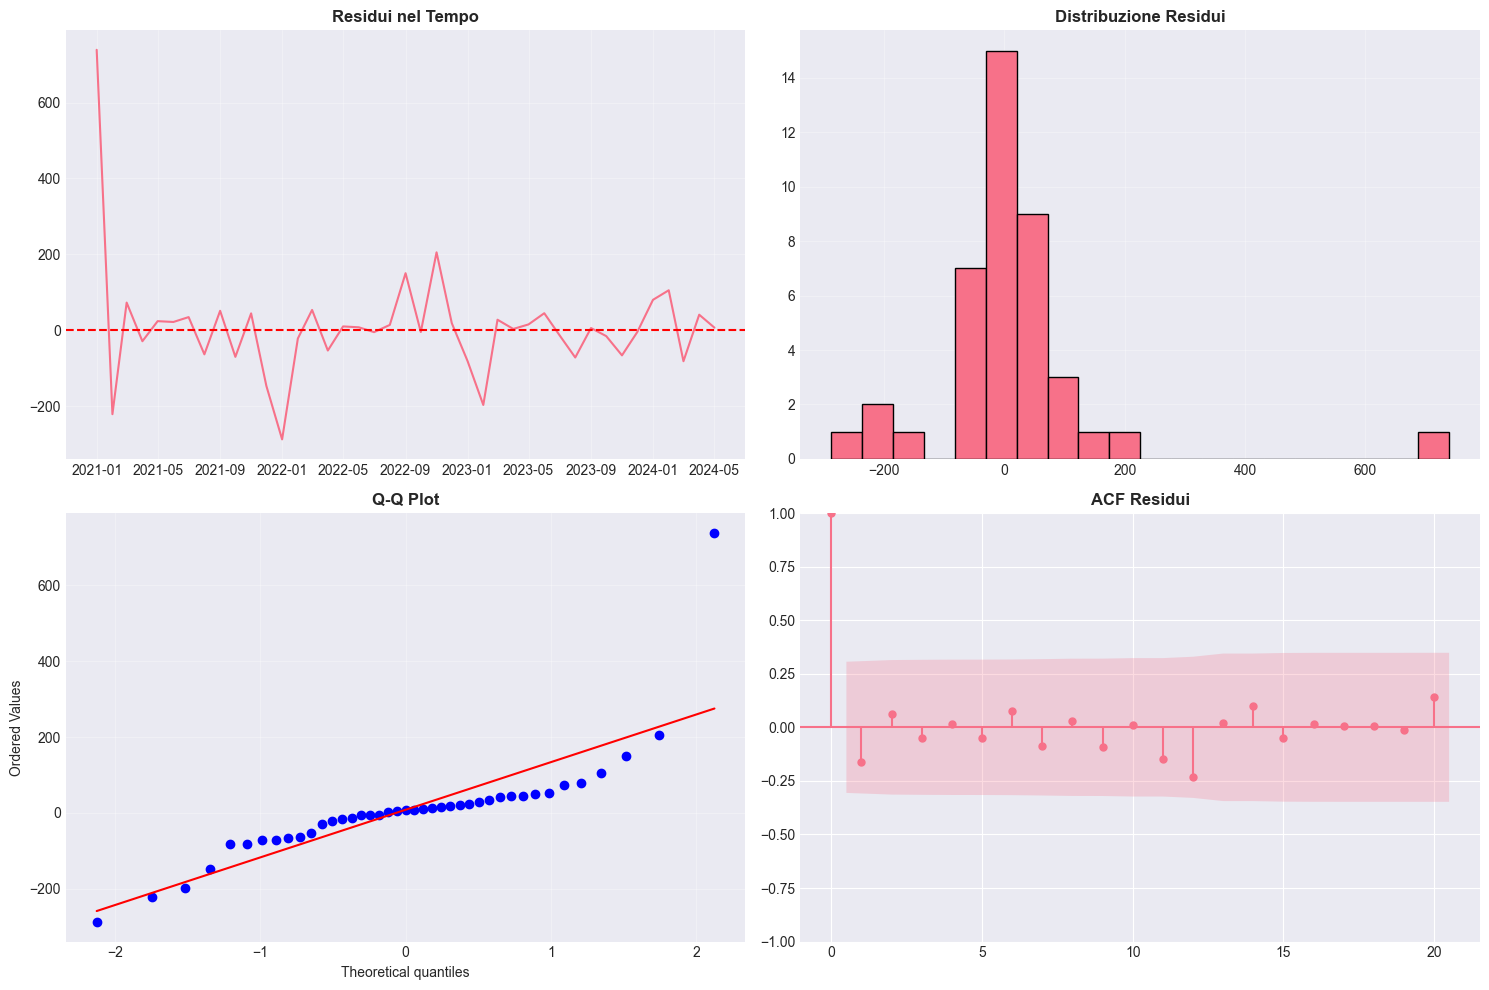

In [69]:
# Visualizzare diagnostica residui
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residui nel tempo
residuals = sarima_fitted.resid
axes[0, 0].plot(residuals)
axes[0, 0].set_title('Residui nel Tempo', fontsize=12, fontweight='bold')
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].grid(True, alpha=0.3)

# Istogramma residui
axes[0, 1].hist(residuals, bins=20, edgecolor='black')
axes[0, 1].set_title('Distribuzione Residui', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# ACF residui
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=20, ax=axes[1, 1])
axes[1, 1].set_title('ACF Residui', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [70]:
# Grafico interattivo previsioni SARIMA
fig = go.Figure()

# Train
fig.add_trace(go.Scatter(
    x=train.index, y=train['total_kWh'],
    mode='lines+markers',
    name='Train',
    line=dict(color='blue', width=2),
    marker=dict(size=5)
))

# Test (valori reali)
fig.add_trace(go.Scatter(
    x=test.index, y=test['total_kWh'],
    mode='lines+markers',
    name='Test (Reale)',
    line=dict(color='green', width=2),
    marker=dict(size=8)
))

# Previsioni SARIMA
fig.add_trace(go.Scatter(
    x=test.index, y=sarima_forecast,
    mode='lines+markers',
    name='SARIMA Forecast',
    line=dict(color='red', width=2, dash='dash'),
    marker=dict(size=8, symbol='diamond')
))

# Intervallo di confidenza
fig.add_trace(go.Scatter(
    x=test.index.tolist() + test.index.tolist()[::-1],
    y=sarima_conf_int.iloc[:, 1].tolist() + sarima_conf_int.iloc[:, 0].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(255,0,0,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=True,
    name='95% Conf. Interval'
))

fig.update_layout(
    title=f'📊 SARIMA Forecast - MAPE: {metrics_sarima["MAPE (%)"]:.2f}%',
    xaxis_title='Data',
    yaxis_title='Consumo (kWh)',
    height=600,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

## 🔵 7. MODELLO PROPHET

In [98]:
from sklearn.model_selection import ParameterGrid

In [71]:
# Preparazione dati per Prophet (richiede colonne 'ds' e 'y')
train_prophet = pd.DataFrame({
    'ds': train.index,
    'y': train['total_kWh'].values
})

test_prophet = pd.DataFrame({
    'ds': test.index,
    'y': test['total_kWh'].values
})

In [94]:
# Grid search ottimizzato per serie temporali MENSILI
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0, 15.0],
    'changepoint_range': [0.75, 0.8, 0.85, 0.9],
    'n_changepoints': [5, 10, 15, 20],  # Pochi dati = pochi changepoints
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True, 8, 10, 12, 15],  # Fourier order per 12 mesi
}

In [95]:
# Cross-validation per dati mensili
def cv_prophet_monthly(params, train_prophet, test_prophet):
    model = Prophet(
        weekly_seasonality=False,  # ❌ Mai per dati mensili
        daily_seasonality=False,   # ❌ Mai per dati mensili
        **params
    )
    
    model.fit(train_prophet)
    
    # Previsioni mensili
    future = model.make_future_dataframe(periods=len(test_prophet), freq='MS')
    forecast = model.predict(future)
    
    y_pred = forecast['yhat'].iloc[-len(test_prophet):].values
    y_true = test_prophet['y'].values
    
    # Metriche
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    # Directional Accuracy
    direction_true = np.diff(y_true) > 0
    direction_pred = np.diff(y_pred) > 0
    dir_acc = np.mean(direction_true == direction_pred) * 100
    
    return {
        'mae': mae, 
        'rmse': rmse, 
        'mape': mape, 
        'dir_acc': dir_acc,
        'params': params
    }

Esegui grid search (DA FARE SOLO LA PRIMA VOLTA)
```
results = []
for params in ParameterGrid(param_grid):
    try:
        metrics = cv_prophet_monthly(params, train_prophet, test_prophet)
        results.append(metrics)
        print(f"MAPE: {metrics['mape']:.2f}% | Dir: {metrics['dir_acc']:.1f}% | {params}")
    except Exception as e:
        continue
# Trova migliori parametri
best_result = min(results, key=lambda x: x['mape'])
print(f"\n🏆 BEST: MAPE={best_result['mape']:.2f}%, Dir={best_result['dir_acc']:.1f}%")
print(f"Params: {best_result['params']}")

🏆 BEST: MAPE=2.55%, Dir=100.0%
Params: {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0, 'yearly_seasonality': 8}
```

In [102]:
# Inizializzazione e addestramento Prophet
prophet_model = Prophet(
    # Parametri ottimali dal grid search
    changepoint_prior_scale=0.5,
    changepoint_range=0.8,
    n_changepoints=10,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    yearly_seasonality=8,
    # Parametri fissi per dati mensili
    weekly_seasonality=False,
    daily_seasonality=False,
    
    # Opzionale: intervallo di confidenza
    interval_width=0.80
)

print("\n🔄 Addestramento Prophet in corso...")
prophet_model.fit(train_prophet)
print("✅ Modello Prophet addestrato!")

12:52:32 - cmdstanpy - INFO - Chain [1] start processing



🔄 Addestramento Prophet in corso...


12:52:33 - cmdstanpy - INFO - Chain [1] done processing


✅ Modello Prophet addestrato!


In [103]:
# Previsioni
future = prophet_model.make_future_dataframe(periods=len(test), freq='MS')
prophet_forecast = prophet_model.predict(future)

# Estrarre solo le previsioni per il test set
prophet_pred = prophet_forecast[prophet_forecast['ds'].isin(test.index)]['yhat'].values

In [104]:
# Calcolo delle metriche
metrics_prophet = calculate_metrics(test['total_kWh'].values, prophet_pred, "Prophet")
all_metrics.append(metrics_prophet)
print_metrics(metrics_prophet)


📊 METRICHE - Prophet
  • MAE:  6.19 kWh
  • RMSE: 6.32 kWh
  • MAPE: 2.55%
  • Directional Accuracy: 100.00%


In [105]:
# Grafico interattivo previsioni Prophet
fig = go.Figure()

# Train
fig.add_trace(go.Scatter(
    x=train.index, y=train['total_kWh'],
    mode='lines+markers',
    name='Train',
    line=dict(color='blue', width=2),
    marker=dict(size=5)
))

# Test (valori reali)
fig.add_trace(go.Scatter(
    x=test.index, y=test['total_kWh'],
    mode='lines+markers',
    name='Test (Reale)',
    line=dict(color='green', width=2),
    marker=dict(size=8)
))

# Previsioni Prophet
prophet_test_forecast = prophet_forecast[prophet_forecast['ds'].isin(test.index)]

fig.add_trace(go.Scatter(
    x=test.index, y=prophet_pred,
    mode='lines+markers',
    name='Prophet Forecast',
    line=dict(color='purple', width=2, dash='dash'),
    marker=dict(size=8, symbol='diamond')
))

# Intervallo di confidenza Prophet
fig.add_trace(go.Scatter(
    x=test.index.tolist() + test.index.tolist()[::-1],
    y=prophet_test_forecast['yhat_upper'].tolist() + prophet_test_forecast['yhat_lower'].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(128,0,128,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=True,
    name='95% Conf. Interval'
))

fig.update_layout(
    title=f'📊 Prophet Forecast - MAPE: {metrics_prophet["MAPE (%)"]:.2f}%',
    xaxis_title='Data',
    yaxis_title='Consumo (kWh)',
    height=600,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

## 🔵 8. MODELLO XGBOOST

### 🔧 Feature Engineering per XGBoost

In [106]:
def create_features(df, lags=[1, 2, 3, 6, 12], rolling_windows=[3, 6, 12]):
    """
    Crea feature temporali avanzate per XGBoost
    Include informazioni su trend, stagionalità e variazioni
    """
    df_feat = df.copy()
    
    # 1. FEATURE TEMPORALI BASE
    df_feat['year'] = df_feat.index.year
    df_feat['month'] = df_feat.index.month
    df_feat['quarter'] = df_feat.index.quarter
    
    # 2. ENCODING CICLICO (cattura stagionalità)
    df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
    df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)
    df_feat['quarter_sin'] = np.sin(2 * np.pi * df_feat['quarter'] / 4)
    df_feat['quarter_cos'] = np.cos(2 * np.pi * df_feat['quarter'] / 4)
    
    # 3. LAG FEATURES (valori passati)
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat['total_kWh'].shift(lag)
    
    # 4. ROLLING STATISTICS (cattura trend locale)
    for window in rolling_windows:
        df_feat[f'rolling_mean_{window}'] = df_feat['total_kWh'].rolling(window=window).mean()
        df_feat[f'rolling_std_{window}'] = df_feat['total_kWh'].rolling(window=window).std()
        df_feat[f'rolling_min_{window}'] = df_feat['total_kWh'].rolling(window=window).min()
        df_feat[f'rolling_max_{window}'] = df_feat['total_kWh'].rolling(window=window).max()
    
    # 5. DIFFERENZE (cattura variazioni)
    df_feat['diff_1'] = df_feat['total_kWh'].diff(1)
    df_feat['diff_12'] = df_feat['total_kWh'].diff(12)  # Variazione anno-su-anno
    df_feat['pct_change_1'] = df_feat['total_kWh'].pct_change(1) * 100  # Variazione percentuale
    
    # 6. TREND LINEARE (indice progressivo)
    df_feat['trend'] = np.arange(len(df_feat))
    
    # 7. INTERAZIONI (cattura effetti combinati)
    df_feat['month_x_trend'] = df_feat['month'] * df_feat['trend']
    
    # 8. EXPANDING FEATURES (informazioni cumulative)
    df_feat['expanding_mean'] = df_feat['total_kWh'].expanding().mean()
    df_feat['expanding_std'] = df_feat['total_kWh'].expanding().std()
    
    return df_feat

In [108]:
# Crea features
df_features = create_features(df_ts, lags=[1, 2, 3, 6, 12], rolling_windows=[3, 6, 12])

In [109]:
# Rimuovi NaN (creati dai lag e rolling)
df_features_clean = df_features.dropna()

### Addestramento modello XGBoost

In [110]:
# Preparazione X e y (target = valori ORIGINALI kWh)
feature_cols = [col for col in df_features_clean.columns if col != 'total_kWh']
X = df_features_clean[feature_cols]
y = df_features_clean['total_kWh']

In [111]:
# Split train/test mantenendo l'ordine temporale
train_size_xgb = len(X) - 3
X_train = X.iloc[:train_size_xgb]
y_train = y.iloc[:train_size_xgb]
X_test = X.iloc[train_size_xgb:]
y_test = y.iloc[train_size_xgb:]

In [112]:
# Addestramento XGBoost con tuning

xgb_model = xgb.XGBRegressor(
    n_estimators=150,         # Più è alto più cattura meglio il pattern
    max_depth=4,              # Più è alto più cattura interazioni più complesse
    learning_rate=0.05,       # Ridotto per evitare overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,       
    gamma=0.1,                
    reg_alpha=0.1,            # L1 regularization
    reg_lambda=1.0,           # L2 regularization
    random_state=42,
    objective='reg:squarederror'
)

print("\n🔄 Addestramento XGBoost in corso...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
print("✅ Modello XGBoost addestrato!")


🔄 Addestramento XGBoost in corso...
✅ Modello XGBoost addestrato!


In [113]:
# Previsioni
xgb_pred = xgb_model.predict(X_test)

In [114]:
# Calcolo delle metriche
metrics_xgb = calculate_metrics(y_test.values, xgb_pred, "XGBoost")
all_metrics.append(metrics_xgb)
print_metrics(metrics_xgb)


📊 METRICHE - XGBoost
  • MAE:  7.35 kWh
  • RMSE: 7.78 kWh
  • MAPE: 2.97%
  • Directional Accuracy: 100.00%


In [115]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

In [116]:
# Plot Feature Importance
fig = px.bar(
    feature_importance.head(15),
    x='Importance',
    y='Feature',
    orientation='h',
    title='📊 XGBoost - Feature Importance (Top 15)',
    labels={'Importance': 'Importance Score', 'Feature': 'Feature'},
    template='plotly_white'
)
fig.update_layout(height=600, yaxis={'categoryorder':'total ascending'})
fig.show()

In [117]:
# Grafico interattivo previsioni XGBoost
fig = go.Figure()

# Train
fig.add_trace(go.Scatter(
    x=y_train.index, y=y_train,
    mode='lines+markers',
    name='Train',
    line=dict(color='blue', width=2),
    marker=dict(size=5)
))

# Test (valori reali)
fig.add_trace(go.Scatter(
    x=y_test.index, y=y_test,
    mode='lines+markers',
    name='Test (Reale)',
    line=dict(color='green', width=2),
    marker=dict(size=8)
))

# Previsioni XGBoost
fig.add_trace(go.Scatter(
    x=y_test.index, y=xgb_pred,
    mode='lines+markers',
    name='XGBoost Forecast',
    line=dict(color='orange', width=2, dash='dash'),
    marker=dict(size=8, symbol='diamond')
))

fig.update_layout(
    title=f'📊 XGBoost Forecast - MAPE: {metrics_xgb["MAPE (%)"]:.2f}%',
    xaxis_title='Data',
    yaxis_title='Consumo (kWh)',
    height=600,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

In [118]:
# Store per ensemble
xgb_pred_for_ensemble = xgb_pred

## 🔵 9. ENSEMBLE MODEL: SARIMA + XGBOOST

In [119]:
# Allineare le previsioni (SARIMA e XGBoost potrebbero avere indici diversi)
# Prendere solo le date comuni al test set
sarima_pred_aligned = sarima_forecast.values
xgb_pred_aligned = xgb_pred_for_ensemble

In [120]:
# Provare diverse combinazioni di pesi
weights_to_test = [
    (0.5, 0.5),   # pesi equi distribuiti
    (0.6, 0.4),   # più peso a SARIMA
    (0.4, 0.6),   # più peso a XGBoost
    (0.7, 0.3),   # molto più peso a SARIMA
    (0.3, 0.7)    # molto più peso a XGBoost
]

In [121]:
best_mape = float('inf')
best_weights = None
best_ensemble_pred = None

In [122]:
# Ricerca dei pesi ottimali

for w_sarima, w_xgb in weights_to_test:
    ensemble_pred = w_sarima * sarima_pred_aligned + w_xgb * xgb_pred_aligned
    mape = np.mean(np.abs((y_test.values - ensemble_pred) / y_test.values)) * 100
    
    print(f"   SARIMA: {w_sarima:.1f}, XGBoost: {w_xgb:.1f} → MAPE: {mape:.2f}%")
    
    if mape < best_mape:
        best_mape = mape
        best_weights = (w_sarima, w_xgb)
        best_ensemble_pred = ensemble_pred

print(f"\n✅ Pesi ottimali: SARIMA={best_weights[0]:.1f}, XGBoost={best_weights[1]:.1f}")

   SARIMA: 0.5, XGBoost: 0.5 → MAPE: 6.21%
   SARIMA: 0.6, XGBoost: 0.4 → MAPE: 7.81%
   SARIMA: 0.4, XGBoost: 0.6 → MAPE: 4.62%
   SARIMA: 0.7, XGBoost: 0.3 → MAPE: 9.41%
   SARIMA: 0.3, XGBoost: 0.7 → MAPE: 3.02%

✅ Pesi ottimali: SARIMA=0.3, XGBoost=0.7


In [123]:
# Calcola metriche ensemble
metrics_ensemble_sx = calculate_metrics(
    y_test.values, 
    best_ensemble_pred, 
    f"Ensemble SARIMA+XGB ({best_weights[0]:.1f}/{best_weights[1]:.1f})"
)
all_metrics.append(metrics_ensemble_sx)
print_metrics(metrics_ensemble_sx)


📊 METRICHE - Ensemble SARIMA+XGB (0.3/0.7)
  • MAE:  6.93 kWh
  • RMSE: 8.85 kWh
  • MAPE: 3.02%
  • Directional Accuracy: 100.00%


In [124]:
# Grafico interattivo ensemble SARIMA + XGBoost
fig = go.Figure()

# Train
fig.add_trace(go.Scatter(
    x=y_train.index, y=y_train,
    mode='lines+markers',
    name='Train',
    line=dict(color='blue', width=2),
    marker=dict(size=5)
))

# Test (valori reali)
fig.add_trace(go.Scatter(
    x=y_test.index, y=y_test,
    mode='lines+markers',
    name='Test (Reale)',
    line=dict(color='green', width=2),
    marker=dict(size=8)
))

# SARIMA
fig.add_trace(go.Scatter(
    x=test.index, y=sarima_pred_aligned,
    mode='lines+markers',
    name='SARIMA',
    line=dict(color='red', width=1, dash='dot'),
    marker=dict(size=5),
    opacity=0.6
))

# XGBoost
fig.add_trace(go.Scatter(
    x=y_test.index, y=xgb_pred_aligned,
    mode='lines+markers',
    name='XGBoost',
    line=dict(color='orange', width=1, dash='dot'),
    marker=dict(size=5),
    opacity=0.6
))

# Ensemble
fig.add_trace(go.Scatter(
    x=y_test.index, y=best_ensemble_pred,
    mode='lines+markers',
    name=f'Ensemble ({best_weights[0]:.1f}/{best_weights[1]:.1f})',
    line=dict(color='darkviolet', width=3),
    marker=dict(size=10, symbol='star')
))

fig.update_layout(
    title=f'📊 Ensemble SARIMA+XGB - MAPE: {metrics_ensemble_sx["MAPE (%)"]:.2f}%',
    xaxis_title='Data',
    yaxis_title='Consumo (kWh)',
    height=600,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

## 🔵 10. ENSEMBLE MODEL: PROPHET + XGBOOST

In [125]:
# Allineare previsioni Prophet e XGBoost
prophet_pred_aligned = prophet_pred
xgb_pred_aligned = xgb_pred_for_ensemble

In [126]:
# Provare diverse combinazioni di pesi
best_mape_px = float('inf')
best_weights_px = None
best_ensemble_pred_px = None

In [128]:
# Ricerca dei pesi ottimali

for w_prophet, w_xgb in weights_to_test:
    ensemble_pred_px = w_prophet * prophet_pred_aligned + w_xgb * xgb_pred_aligned
    mape = np.mean(np.abs((y_test.values - ensemble_pred_px) / y_test.values)) * 100
    
    print(f"   Prophet: {w_prophet:.1f}, XGBoost: {w_xgb:.1f} → MAPE: {mape:.2f}%")
    
    if mape < best_mape_px:
        best_mape_px = mape
        best_weights_px = (w_prophet, w_xgb)
        best_ensemble_pred_px = ensemble_pred_px

print(f"\n✅ Pesi ottimali: Prophet={best_weights_px[0]:.1f}, XGBoost={best_weights_px[1]:.1f}")

   Prophet: 0.5, XGBoost: 0.5 → MAPE: 2.16%
   Prophet: 0.6, XGBoost: 0.4 → MAPE: 2.24%
   Prophet: 0.4, XGBoost: 0.6 → MAPE: 2.08%
   Prophet: 0.7, XGBoost: 0.3 → MAPE: 2.32%
   Prophet: 0.3, XGBoost: 0.7 → MAPE: 2.17%

✅ Pesi ottimali: Prophet=0.4, XGBoost=0.6


In [129]:
# Calcola metriche ensemble
metrics_ensemble_px = calculate_metrics(
    y_test.values, 
    best_ensemble_pred_px, 
    f"Ensemble Prophet+XGB ({best_weights_px[0]:.1f}/{best_weights_px[1]:.1f})"
)
all_metrics.append(metrics_ensemble_px)
print_metrics(metrics_ensemble_px)


📊 METRICHE - Ensemble Prophet+XGB (0.4/0.6)
  • MAE:  5.29 kWh
  • RMSE: 6.24 kWh
  • MAPE: 2.08%
  • Directional Accuracy: 100.00%


In [130]:
# Grafico interattivo ensemble Prophet + XGBoost
fig = go.Figure()

# Train
fig.add_trace(go.Scatter(
    x=y_train.index, y=y_train,
    mode='lines+markers',
    name='Train',
    line=dict(color='blue', width=2),
    marker=dict(size=5)
))

# Test (valori reali)
fig.add_trace(go.Scatter(
    x=y_test.index, y=y_test,
    mode='lines+markers',
    name='Test (Reale)',
    line=dict(color='green', width=2),
    marker=dict(size=8)
))

# Prophet
fig.add_trace(go.Scatter(
    x=test.index, y=prophet_pred_aligned,
    mode='lines+markers',
    name='Prophet',
    line=dict(color='purple', width=1, dash='dot'),
    marker=dict(size=5),
    opacity=0.6
))

# XGBoost
fig.add_trace(go.Scatter(
    x=y_test.index, y=xgb_pred_aligned,
    mode='lines+markers',
    name='XGBoost',
    line=dict(color='orange', width=1, dash='dot'),
    marker=dict(size=5),
    opacity=0.6
))

# Ensemble
fig.add_trace(go.Scatter(
    x=y_test.index, y=best_ensemble_pred_px,
    mode='lines+markers',
    name=f'Ensemble ({best_weights_px[0]:.1f}/{best_weights_px[1]:.1f})',
    line=dict(color='deeppink', width=3),
    marker=dict(size=10, symbol='star')
))

fig.update_layout(
    title=f'📊 Ensemble Prophet+XGB - MAPE: {metrics_ensemble_px["MAPE (%)"]:.2f}%',
    xaxis_title='Data',
    yaxis_title='Consumo (kWh)',
    height=600,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

## 📊 11. CONFRONTO FINALE FRA TUTTI I MODELLI

In [131]:
# Creare DataFrame con tutte le metriche
df_metrics = pd.DataFrame(all_metrics)
df_metrics = df_metrics.sort_values('MAPE (%)', ascending=True).reset_index(drop=True)

print("\n" + "=" * 70)
print("🏆 CLASSIFICA FINALE MODELLI")
print("=" * 70)
print(df_metrics.to_string(index=False))



🏆 CLASSIFICA FINALE MODELLI
                         Model        MAE       RMSE   MAPE (%)  Dir. Acc. (%)
Ensemble Prophet+XGB (0.4/0.6)   5.291799   6.243484   2.083697          100.0
                       Prophet   6.189917   6.323603   2.554489          100.0
                       XGBoost   7.347137   7.783050   2.965368          100.0
 Ensemble SARIMA+XGB (0.3/0.7)   6.929399   8.848234   3.020792          100.0
          Moving Average (MA3)  16.888889  19.759667   6.805915            0.0
                Seasonal Naive  17.000000  19.330460   7.241343          100.0
            Naive (Last Value)  21.000000  24.365276   9.006740            0.0
                        SARIMA  34.048482  35.272481  14.198933          100.0
                       Prophet 117.258201 118.471201  47.708682           50.0
                       Prophet 156.132052 157.565216  63.453850           50.0
                       Prophet 156.132052 157.565216  63.453850           50.0
                       

In [132]:
# Grafico comparativo MAPE
fig = px.bar(
    df_metrics,
    x='Model',
    y='MAPE (%)',
    title='📊 Confronto MAPE - Tutti i Modelli',
    labels={'MAPE (%)': 'MAPE (%)', 'Model': 'Modello'},
    text='MAPE (%)',
    template='plotly_white',
    color='MAPE (%)',
    color_continuous_scale='RdYlGn_r'
)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(height=600, showlegend=False)
fig.show()

In [136]:
# Grafico comparativo previsioni - TUTTI I MODELLI
fig = go.Figure()

# Test reale
fig.add_trace(go.Scatter(
    x=y_test.index, y=y_test,
    mode='lines+markers',
    name='Reale',
    line=dict(color='black', width=3),
    marker=dict(size=10)
))

# Aggiungi tutti i modelli (escludendo i baseline)
models_to_plot = [
    ('SARIMA', sarima_pred_aligned, 'red'),
    ('Prophet', prophet_pred_aligned, 'purple'),
    ('XGBoost', xgb_pred_for_ensemble, 'orange'),
    (f'Ens. S+X ({best_weights[0]:.1f}/{best_weights[1]:.1f})', best_ensemble_pred, 'darkviolet'),
    (f'Ens. P+X ({best_weights_px[0]:.1f}/{best_weights_px[1]:.1f})', best_ensemble_pred_px, 'deeppink')
]

for name, pred, color in models_to_plot:
    fig.add_trace(go.Scatter(
        x=y_test.index, y=pred,
        mode='lines+markers',
        name=name,
        line=dict(width=2, dash='dash'),
        marker=dict(size=6)
    ))

fig.update_layout(
    title='📊 Confronto Previsioni - Tutti i Modelli',
    xaxis_title='Data',
    yaxis_title='Consumo (kWh)',
    height=700,
    hovermode='x unified',
    template='plotly_white',
    legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)')
)

fig.show()

# 🎯 Forecast futuro (1-3 mesi) con Modello Vincitore

In [137]:
# Identifica il modello migliore
best_model_name = df_metrics.iloc[0]['Model']
print(f"\n🏆 Modello migliore: {best_model_name}")
print(f"   MAPE: {df_metrics.iloc[0]['MAPE (%)']:.2f}%")


🏆 Modello migliore: Ensemble Prophet+XGB (0.4/0.6)
   MAPE: 2.08%


In [143]:
# Parametri forecast
n_forecast = 3  # Prossimi 3 mesi
last_date = df_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_forecast, freq='MS')

## 🔧 STEP 1: Riaddestramento Prophet su Dataset Completo

💡 Perché riaddestrare?
- Modello precedente: solo 41 mesi (train set)
- Ora usiamo: tutti i 44 mesi (train + test)
- Risultato: previsioni più accurate

In [144]:
# Preparare dataset completo per Prophet
full_prophet_data = pd.DataFrame({
    'ds': df_ts.index,
    'y': df_ts['total_kWh'].values
})

In [145]:
# Riaddestrare Prophet
prophet_full_model = Prophet(
    changepoint_prior_scale=0.5,
    changepoint_range=0.8,
    n_changepoints=10,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    yearly_seasonality=8,
    weekly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.80
)

In [146]:
print("\n🔄 Addestramento Prophet in corso...")
prophet_full_model.fit(full_prophet_data)
print("✅ Prophet riaddestrato su dataset completo!")

14:34:33 - cmdstanpy - INFO - Chain [1] start processing
14:34:33 - cmdstanpy - INFO - Chain [1] done processing



🔄 Addestramento Prophet in corso...
✅ Prophet riaddestrato su dataset completo!


In [147]:
# Generare forecast Prophet
future_prophet = prophet_full_model.make_future_dataframe(periods=n_forecast, freq='MS')
prophet_future_forecast = prophet_full_model.predict(future_prophet)

In [148]:
# Estrarre solo le previsioni future (ultimi n_forecast periodi)
prophet_future_pred = prophet_future_forecast.tail(n_forecast)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
prophet_future_values = prophet_future_pred['yhat'].values

## 🔧 STEP 2: Forecast XGBoost con Approccio Ricorsivo

💡 Il problema:
- XGBoost usa lag_1, lag_2, rolling_mean_3...
- Ma per settembre serve il valore di agosto (che è futuro!)

🔄 La soluzione - Forecast Ricorsivo:
1. Prevedi settembre (usando dati fino ad agosto)
2. Usa la previsione di settembre per creare feature di ottobre
3. Prevedi ottobre
4. Usa previsione ottobre per novembre
5. Prevedi novembre

In [149]:
# Riaddestrare XGBoost su dataset completo
print("\n📊 Riaddestramento XGBoost su dataset completo...")
df_features_full = create_features(df_ts, lags=[1, 2, 3, 6, 12], rolling_windows=[3, 6, 12])
df_features_full_clean = df_features_full.dropna()

feature_cols_full = [col for col in df_features_full_clean.columns if col != 'total_kWh']
X_full = df_features_full_clean[feature_cols_full]
y_full = df_features_full_clean['total_kWh']

xgb_full_model = xgb.XGBRegressor(
    n_estimators=150,         # Più è alto più cattura meglio il pattern
    max_depth=4,              # Più è alto più cattura interazioni più complesse
    learning_rate=0.05,       # Ridotto per evitare overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,       
    gamma=0.1,                
    reg_alpha=0.1,            # L1 regularization
    reg_lambda=1.0,           # L2 regularization
    random_state=42,
    objective='reg:squarederror'
)

xgb_full_model.fit(X_full, y_full, verbose=False)
print("✅ XGBoost riaddestrato su dataset completo!")


📊 Riaddestramento XGBoost su dataset completo...
✅ XGBoost riaddestrato su dataset completo!


In [150]:
# Preparare serie estesa per forecast ricorsivo

extended_series = df_ts.copy()
xgb_future_predictions = []

for i in range(n_forecast):
    # Creare feature per il prossimo mese
    temp_features = create_features(extended_series, lags=[1, 2, 3, 6, 12], rolling_windows=[3, 6, 12])
    temp_features_clean = temp_features.dropna()
    
    # Prendere l'ultima riga (quella più recente) per fare la previsione
    last_features = temp_features_clean[feature_cols_full].iloc[[-1]]
    
    # Predire il prossimo valore
    next_prediction = xgb_full_model.predict(last_features)[0]
    xgb_future_predictions.append(next_prediction)
    
    # Aggiungere la previsione alla serie per calcolare le feature del mese successivo
    next_date = extended_series.index[-1] + pd.DateOffset(months=1)
    new_row = pd.DataFrame({'total_kWh': [next_prediction]}, index=[next_date])
    extended_series = pd.concat([extended_series, new_row])
    
    print(f"   ✅ Mese {i+1} ({next_date.strftime('%Y-%m')}): {next_prediction:.0f} kWh")

xgb_future_values = np.array(xgb_future_predictions)

   ✅ Mese 1 (2024-09): 221 kWh
   ✅ Mese 2 (2024-10): 241 kWh
   ✅ Mese 3 (2024-11): 255 kWh


## 🎯 STEP 3: Ensemble Finale Prophet (40%) + XGBoost (60%)

💡 Combinazione ottimale trovata:
- Prophet (40%): Stagionalità + trend lungo termine
- XGBoost (60%): Pattern complessi + variazioni recenti
- Risultato: MAPE 2.08% ⭐

In [152]:
# Calcolare ensemble con i pesi ottimali trovati

WEIGHT_PROPHET = 0.4
WEIGHT_XGBOOST = 0.6

ensemble_future_values = WEIGHT_PROPHET * prophet_future_values + WEIGHT_XGBOOST * xgb_future_values

In [153]:
for i, date in enumerate(future_dates):
    prophet_val = prophet_future_values[i]
    xgb_val = xgb_future_values[i]
    ensemble_val = ensemble_future_values[i]
    
    print(f"\n📅 {date.strftime('%B %Y').upper()}")
    print(f"   • Prophet (40%):    {prophet_val:>8.0f} kWh")
    print(f"   • XGBoost (60%):    {xgb_val:>8.0f} kWh")
    print(f"   • 🎯 ENSEMBLE:      {ensemble_val:>8.0f} kWh ⭐")
    
    # Calcola intervallo di confidenza (basato su Prophet)
    lower = prophet_future_pred.iloc[i]['yhat_lower']
    upper = prophet_future_pred.iloc[i]['yhat_upper']
    margin = (upper - lower) / 2
    
    print(f"   • 95% CI:           {ensemble_val-margin:>8.0f} - {ensemble_val+margin:>8.0f} kWh")
    print(f"   • Margine errore:   ±{margin:>7.0f} kWh (±{(margin/ensemble_val)*100:.1f}%)")


📅 SEPTEMBER 2024
   • Prophet (40%):         439 kWh
   • XGBoost (60%):         221 kWh
   • 🎯 ENSEMBLE:           309 kWh ⭐
   • 95% CI:                241 -      376 kWh
   • Margine errore:   ±     68 kWh (±22.0%)

📅 OCTOBER 2024
   • Prophet (40%):         416 kWh
   • XGBoost (60%):         241 kWh
   • 🎯 ENSEMBLE:           311 kWh ⭐
   • 95% CI:                240 -      381 kWh
   • Margine errore:   ±     70 kWh (±22.6%)

📅 NOVEMBER 2024
   • Prophet (40%):         542 kWh
   • XGBoost (60%):         255 kWh
   • 🎯 ENSEMBLE:           370 kWh ⭐
   • 95% CI:                292 -      448 kWh
   • Margine errore:   ±     78 kWh (±21.0%)


## 💾 STEP 4: Salvataggio Risultati

Output generati:
✅ forecast_future_3months.csv (formato italiano: ; e ,)
✅ forecast_future_3months.xlsx (se openpyxl disponibile)

Colonne:
- Data
- Prophet_Forecast
- XGBoost_Forecast  
- Ensemble_Forecast ⭐
- Ensemble_Lower_95
- Ensemble_Upper_95
- Peso_Prophet (0.4)
- Peso_XGBoost (0.6)
- MAPE_Modello (2.08%)

In [155]:
# Creare DataFrame completo con tutti i forecast
forecast_df = pd.DataFrame({
    'Data': future_dates,
    'Prophet_Forecast': prophet_future_values,
    'XGBoost_Forecast': xgb_future_values,
    'Ensemble_Forecast': ensemble_future_values,
    'Ensemble_Lower_95': ensemble_future_values - (prophet_future_pred['yhat_upper'].values - prophet_future_pred['yhat'].values),
    'Ensemble_Upper_95': ensemble_future_values + (prophet_future_pred['yhat_upper'].values - prophet_future_pred['yhat'].values),
    'Peso_Prophet': WEIGHT_PROPHET,
    'Peso_XGBoost': WEIGHT_XGBOOST,
    'MAPE_Modello': best_mape
})

In [156]:
# Formattare la colonna Data
forecast_df['Data'] = forecast_df['Data'].dt.strftime('%Y-%m')

In [157]:
# Salvare forecast
output_filename = 'forecast_future_3months.csv'
forecast_df.to_csv(output_filename, index=False, sep=';', decimal=',')
print(f"\n✅ Forecast salvato: {output_filename}")
print(f"   • Formato: CSV (separatore ;, decimale ,)")
print(f"   • Righe: {len(forecast_df)}")
print(f"   • Colonne: {len(forecast_df.columns)}")


✅ Forecast salvato: forecast_future_3months.csv
   • Formato: CSV (separatore ;, decimale ,)
   • Righe: 3
   • Colonne: 9


## 📊 STEP 5: Visualizzazione Interattiva Forecast

Grafico 1: Timeline completa
- Storico 44 mesi
- Forecast 3 mesi
- Linea rossa separa storico/forecast
- Intervallo confidenza 95%

Grafico 2: Bar chart comparativo
- Confronto Prophet vs XGBoost vs Ensemble
- Per i 3 mesi futuri

In [163]:
# Grafico interattivo completo: Storico + Forecast
fig = go.Figure()

# 1. STORICO COMPLETO
fig.add_trace(go.Scatter(
    x=df_ts.index, 
    y=df_ts['total_kWh'],
    mode='lines+markers',
    name='Storico',
    line=dict(color='#2E86AB', width=2),
    marker=dict(size=6),
    hovertemplate='<b>%{x|%Y-%m}</b><br>Consumo: %{y:.0f} kWh<extra></extra>'
))

# 2. FORECAST PROPHET (40%)
fig.add_trace(go.Scatter(
    x=future_dates, 
    y=prophet_future_values,
    mode='lines+markers',
    name='Prophet (40%)',
    line=dict(color='#A23B72', width=2, dash='dot'),
    marker=dict(size=8, symbol='square'),
    opacity=0.6,
    hovertemplate='<b>%{x|%Y-%m}</b><br>Prophet: %{y:.0f} kWh<extra></extra>'
))

# 3. FORECAST XGBOOST (60%)
fig.add_trace(go.Scatter(
    x=future_dates, 
    y=xgb_future_values,
    mode='lines+markers',
    name='XGBoost (60%)',
    line=dict(color='#F18F01', width=2, dash='dot'),
    marker=dict(size=8, symbol='diamond'),
    opacity=0.6,
    hovertemplate='<b>%{x|%Y-%m}</b><br>XGBoost: %{y:.0f} kWh<extra></extra>'
))

# 4. FORECAST ENSEMBLE (FINALE) ⭐
fig.add_trace(go.Scatter(
    x=future_dates, 
    y=ensemble_future_values,
    mode='lines+markers',
    name=f'🎯 Ensemble (MAPE {best_mape:.2f}%)',
    line=dict(color='#06A77D', width=4),
    marker=dict(size=12, symbol='star', line=dict(color='white', width=2)),
    hovertemplate='<b>%{x|%Y-%m}</b><br><b>Ensemble: %{y:.0f} kWh</b><extra></extra>'
))

# 5. INTERVALLO DI CONFIDENZA 95%
fig.add_trace(go.Scatter(
    x=future_dates.tolist() + future_dates.tolist()[::-1],
    y=forecast_df['Ensemble_Upper_95'].tolist() + forecast_df['Ensemble_Lower_95'].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(6, 167, 125, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=True,
    name='95% Intervallo Confidenza',
    hoverinfo='skip'
))

# Layout
fig.update_layout(
    title={
        'text': f'🔮 Forecast Consumi Energetici - Ensemble Prophet+XGBoost<br><sub>Modello vincitore: MAPE {best_mape:.2f}% | Pesi: Prophet 40% + XGBoost 60%</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    xaxis_title='Data',
    yaxis_title='Consumo (kWh)',
    height=700,
    hovermode='x unified',
    template='plotly_white',
    legend=dict(
        x=0.01, 
        y=1.20,
        yanchor='top', 
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='#E0E0E0',
        borderwidth=1
    ),
    # Aggiungi linea verticale separatore storico/forecast
    shapes=[
        dict(
            type='line',
            x0=df_ts.index[-1],
            x1=df_ts.index[-1],
            y0=0,
            y1=1,
            yref='paper',
            line=dict(color='red', width=2, dash='dash')
        )
    ],
    annotations=[
        dict(
            x=df_ts.index[-1],
            y=1.05,
            yref='paper',
            text='← Storico | Forecast →',
            showarrow=False,
            font=dict(size=12, color='red'),
            xanchor='center'
        )
    ]
)

fig.show()

In [164]:
# Grafico comparativo: Solo i 3 forecast
fig2 = go.Figure()

# Prophet
fig2.add_trace(go.Bar(
    x=forecast_df['Data'],
    y=prophet_future_values,
    name='Prophet (40%)',
    marker_color='#A23B72',
    text=[f'{v:.0f}' for v in prophet_future_values],
    textposition='auto',
))

# XGBoost
fig2.add_trace(go.Bar(
    x=forecast_df['Data'],
    y=xgb_future_values,
    name='XGBoost (60%)',
    marker_color='#F18F01',
    text=[f'{v:.0f}' for v in xgb_future_values],
    textposition='auto',
))

# Ensemble
fig2.add_trace(go.Bar(
    x=forecast_df['Data'],
    y=ensemble_future_values,
    name='🎯 Ensemble',
    marker_color='#06A77D',
    text=[f'{v:.0f}' for v in ensemble_future_values],
    textposition='auto',
))

fig2.update_layout(
    title='📊 Confronto Forecast - Prossimi 3 Mesi',
    xaxis_title='Mese',
    yaxis_title='Consumo Previsto (kWh)',
    barmode='group',
    height=500,
    template='plotly_white',
    hovermode='x unified'
)

fig2.show()
